In [1]:
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [4]:
file_names = ["CAL.csv", "CAR.csv", "CENT.csv", "FLA.csv", "MIDA.csv", "MIDW.csv", "NE.csv", "NW.csv", "NY.csv", "SE.csv",
              "SW.csv", "TEN.csv", "TEX.csv"]

directory = "../Data/Preprocessed"

column_dtypes = {
    'Demand (MW)': 'float64',
    'Net Generation (MW)': 'float64'
}

combined_regions_df = list()

for file_name in file_names:
    file_path = os.path.join(directory, file_name)
    df = pd.read_csv(file_path, parse_dates=['UTC Time at End of Hour'], dtype=column_dtypes, index_col='UTC Time at End of Hour')
    combined_regions_df.append(df)

combined_regions_df[0]

Demand (MW)  Net Generation (MW)
UTC Time at End of Hour                                  
2015-07-01                  615661.0             513680.0
2015-07-02                  964443.0             814879.0
2015-07-03                  904339.0             757794.0
2015-07-04                  863264.0             691081.0
2015-07-05                  801034.0             625964.0
...                              ...                  ...
2022-02-24                  736095.0             590778.0
2022-02-25                  715972.0             549518.0
2022-02-26                  668087.0             461661.0
2022-02-27                  609038.0             423314.0
2022-02-28                  646853.0             436317.0

[2435 rows x 2 columns]

In [6]:
# Generate train and test dataframes
train_df_lst = []
test_df_lst = []
for i in range(len(combined_regions_df)):
    train_size = int(len(combined_regions_df[i]) * 0.90) # 90 % data in train set
    train_df, test_df = combined_regions_df[i][0:train_size], combined_regions_df[i][train_size:]
    train_df_lst.append(train_df)
    test_df_lst.append(test_df)

In [50]:
def plot_seasonal_decompose(df, col, title, pos):
    cal_result = seasonal_decompose(df[col])
    plt.rcParams["figure.figsize"] = (20, 8)
    cal_result.plot()
    plt.suptitle(title, x = pos)
    plt.show()

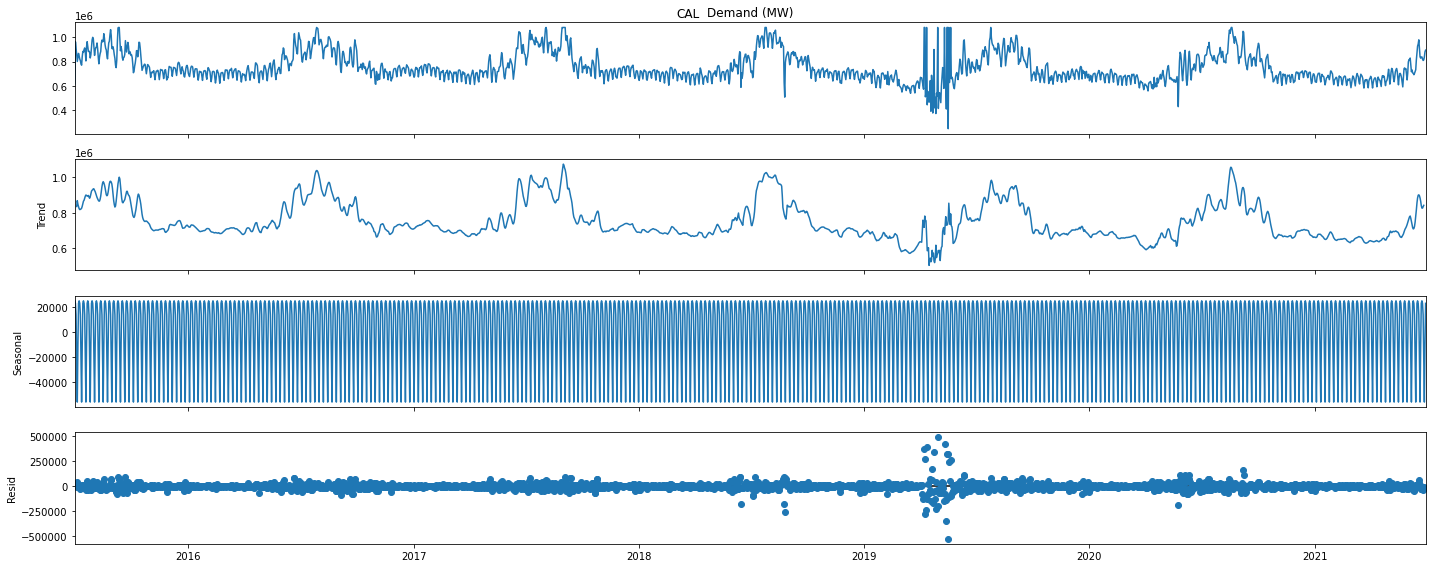

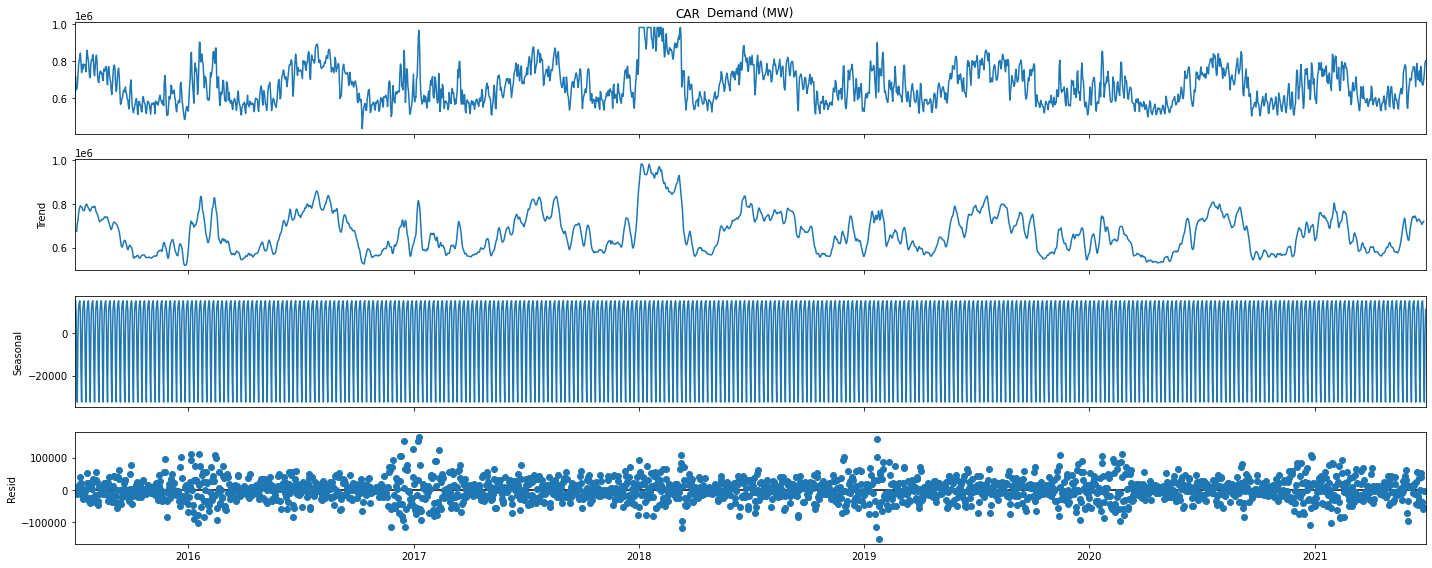

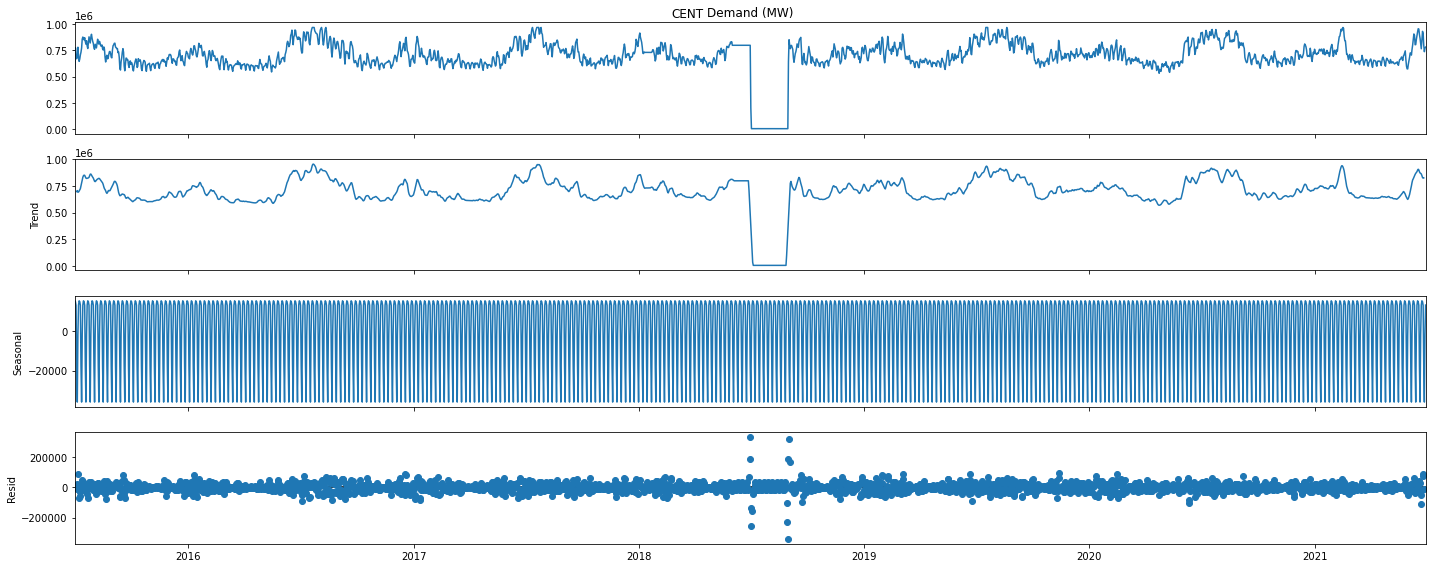

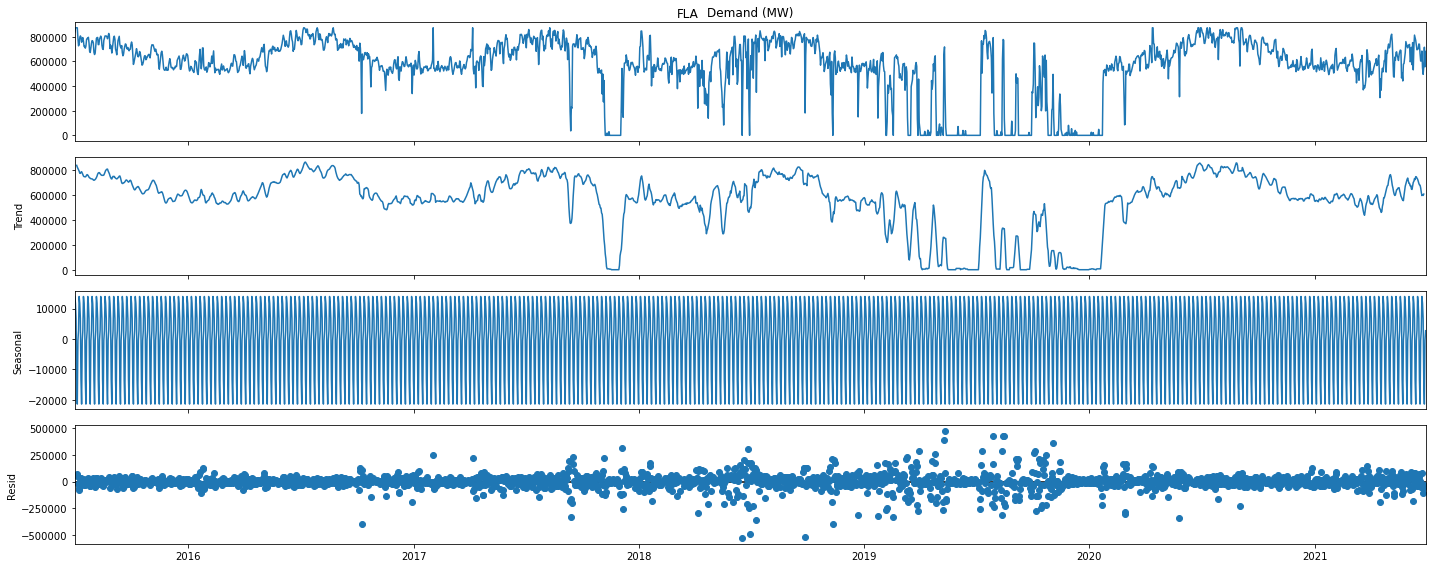

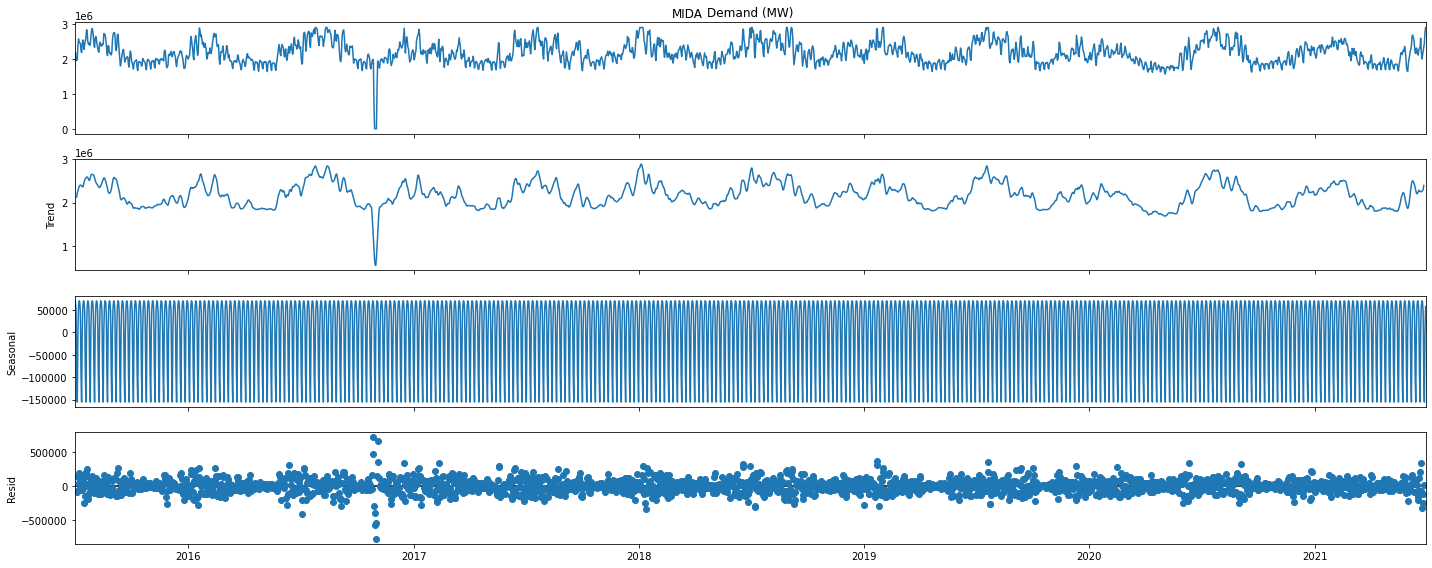

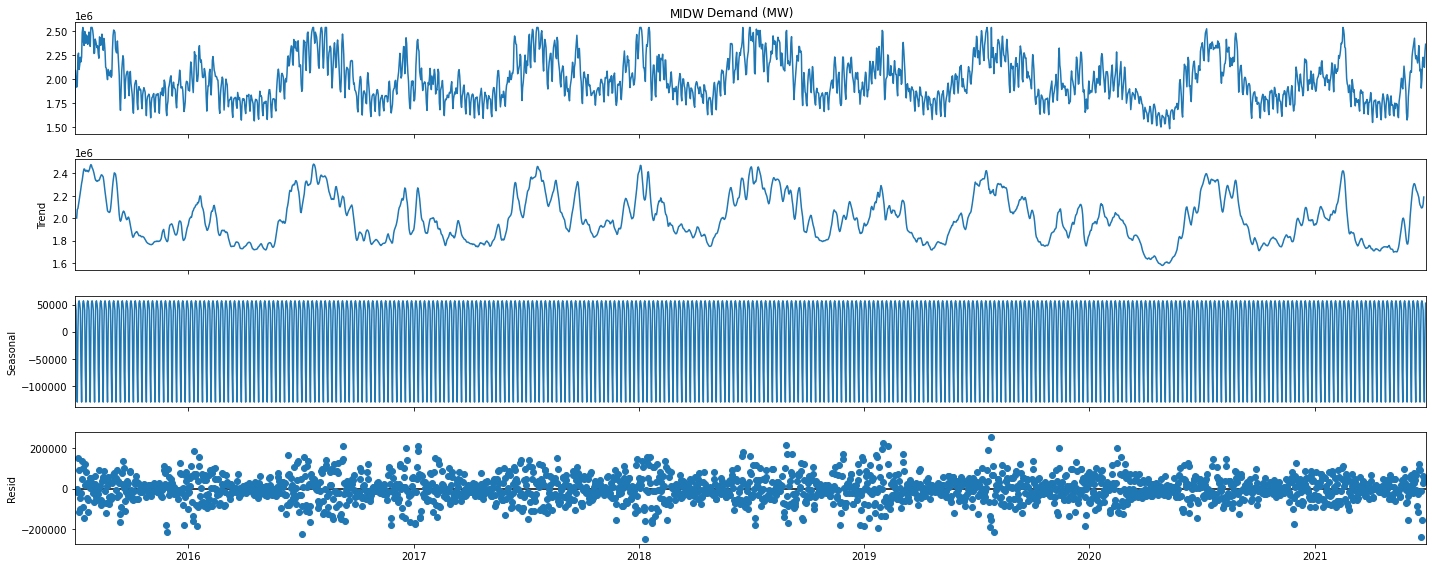

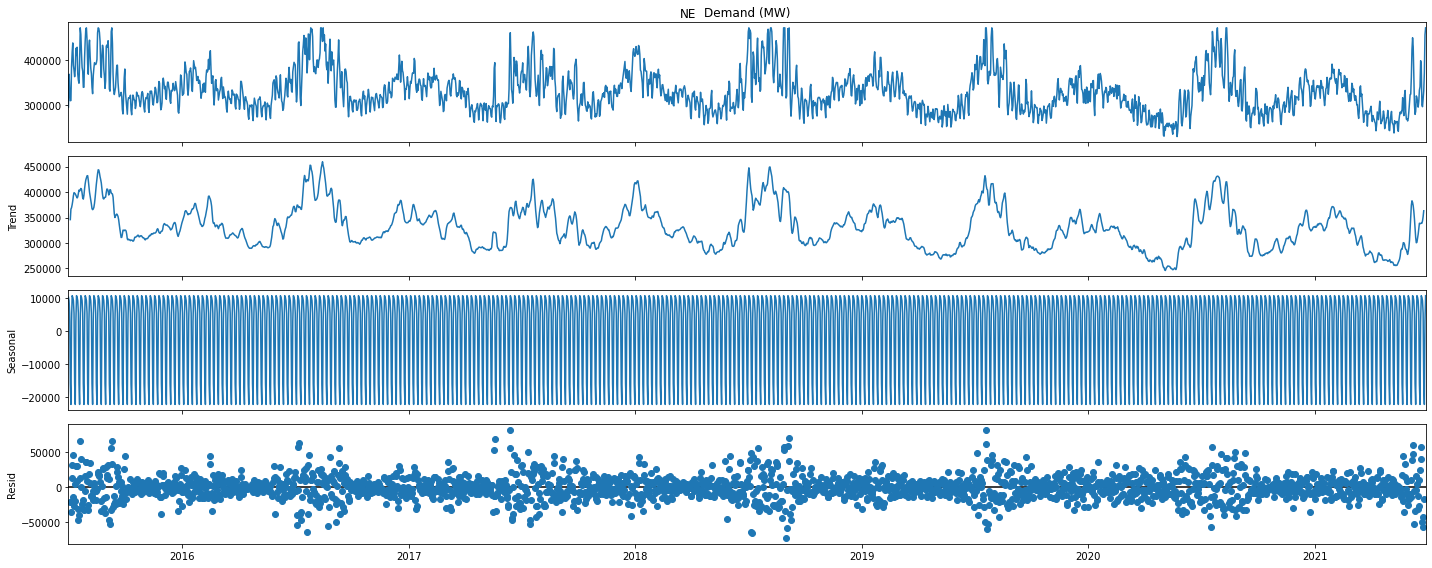

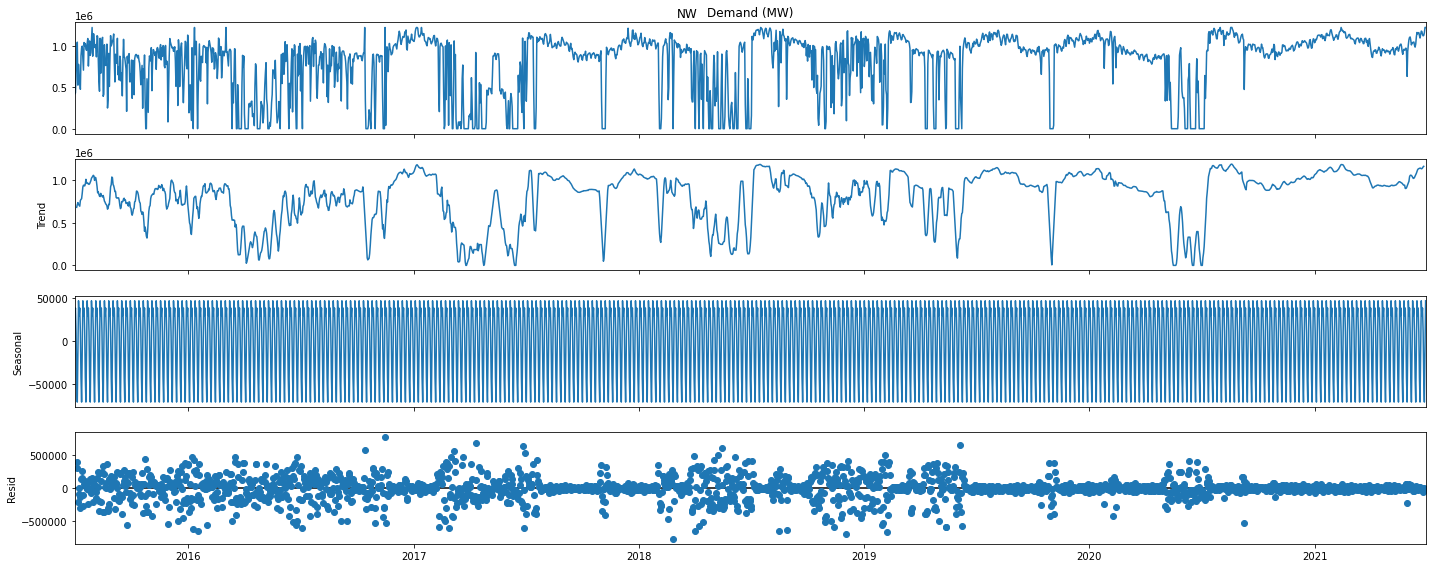

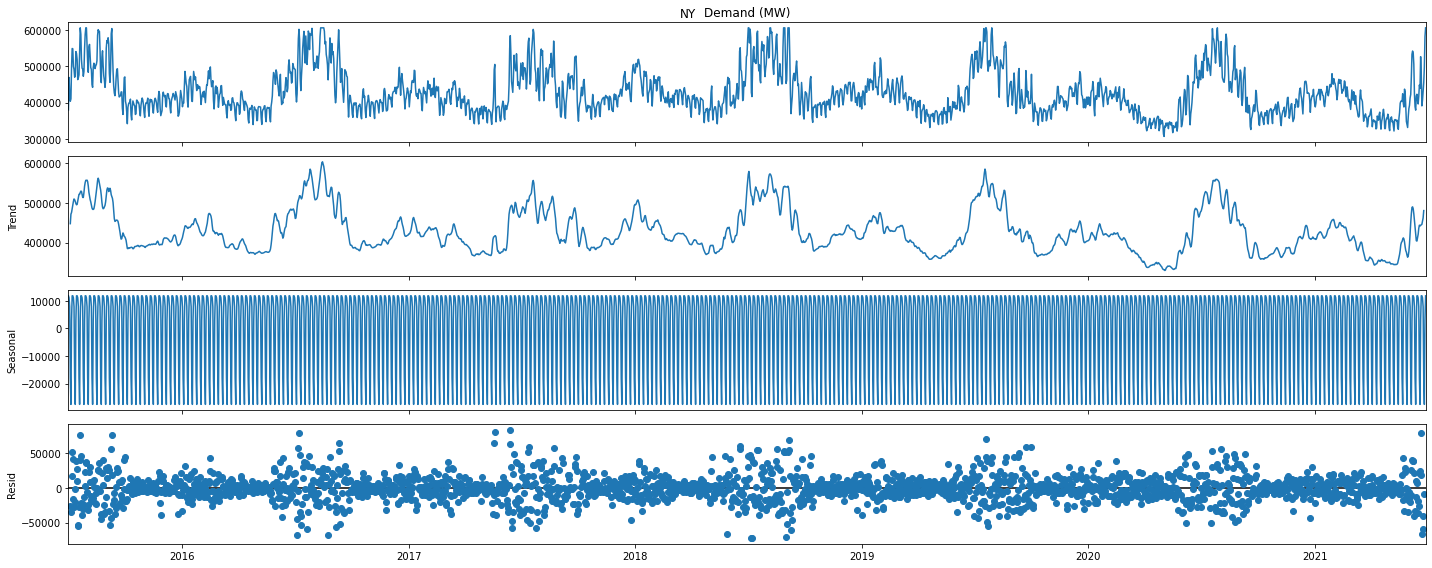

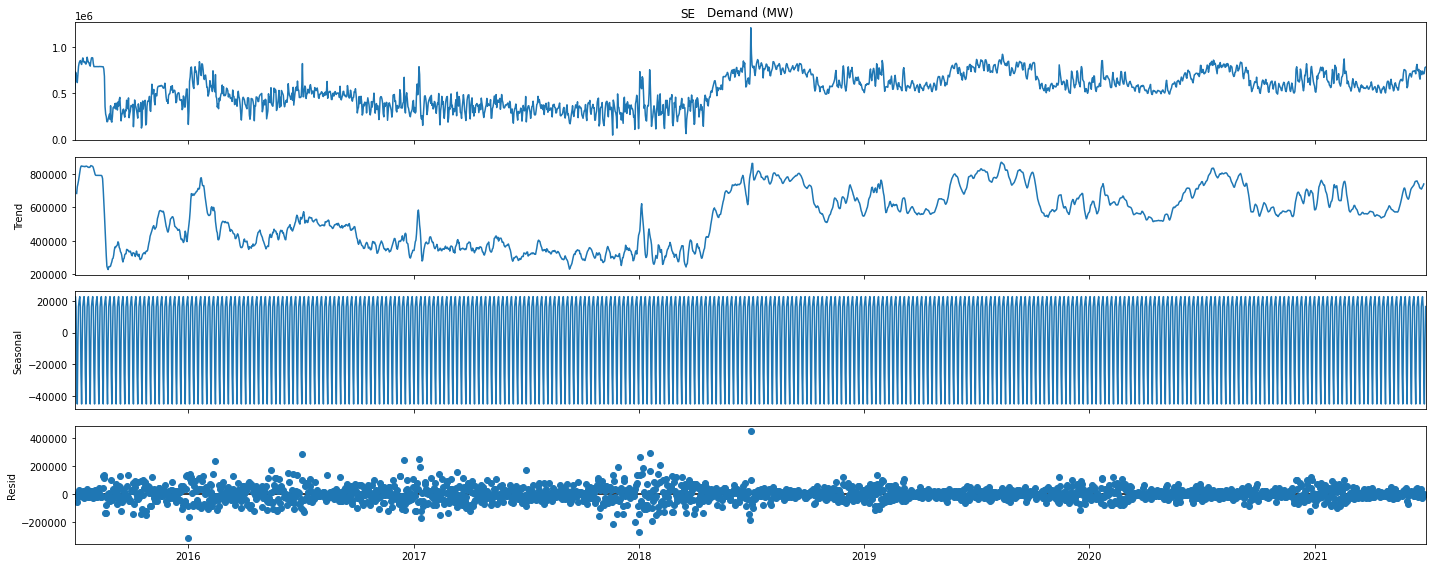

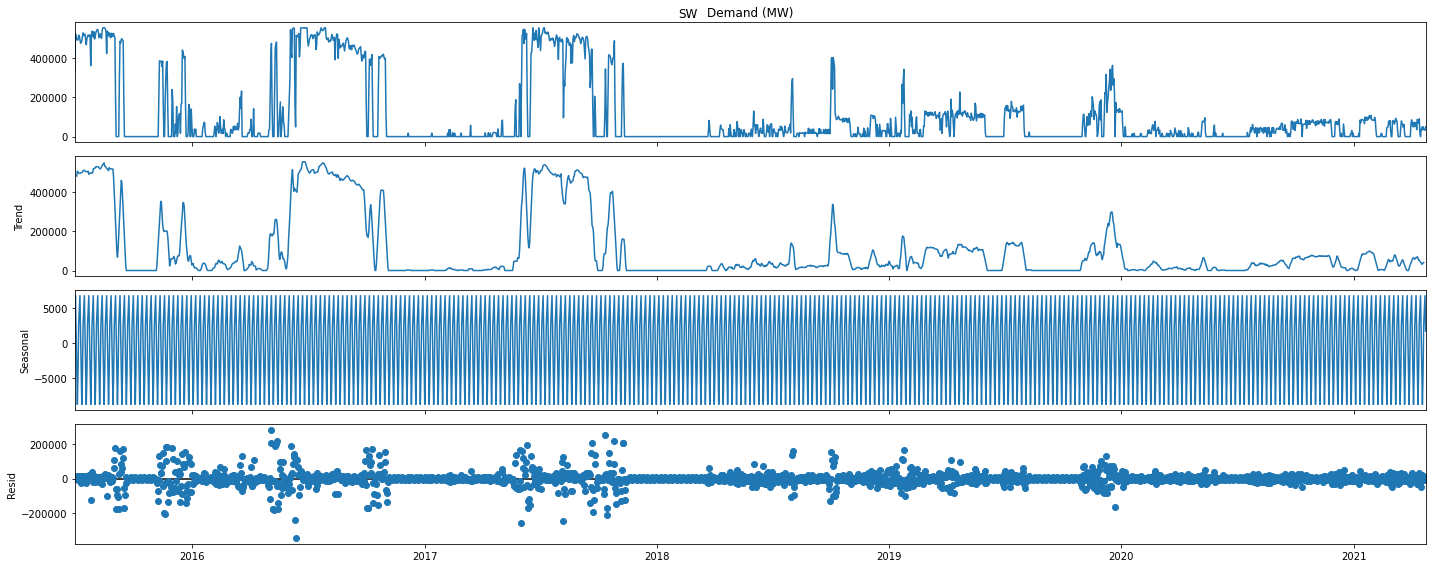

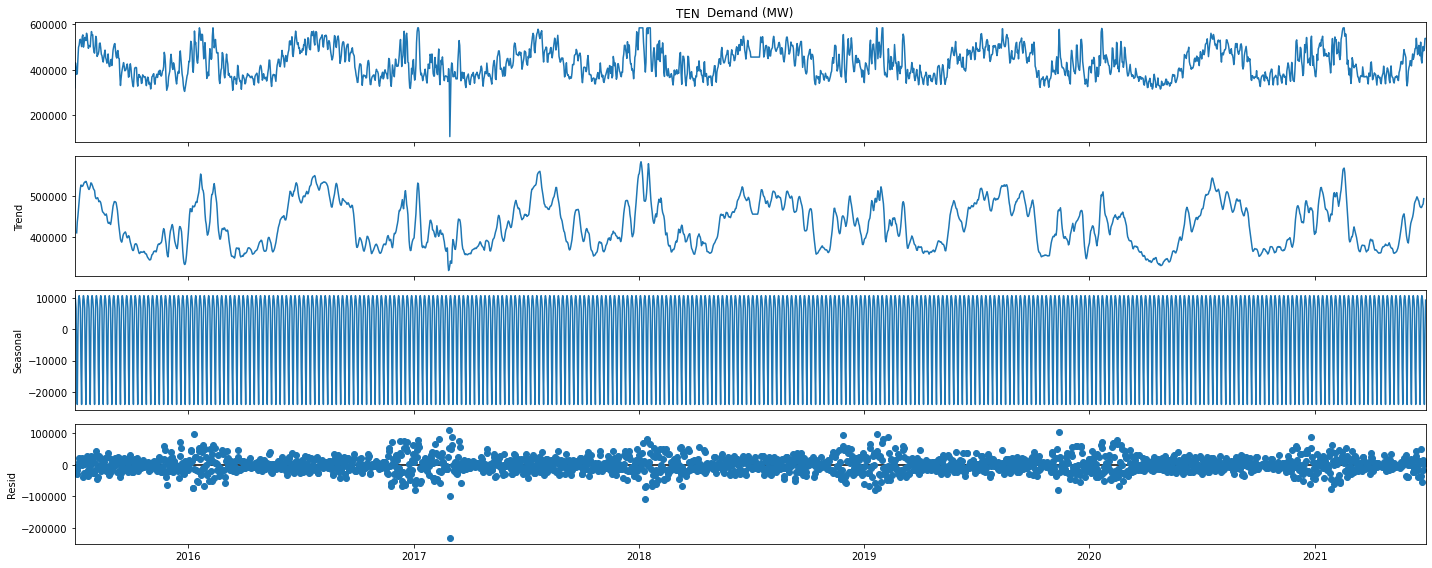

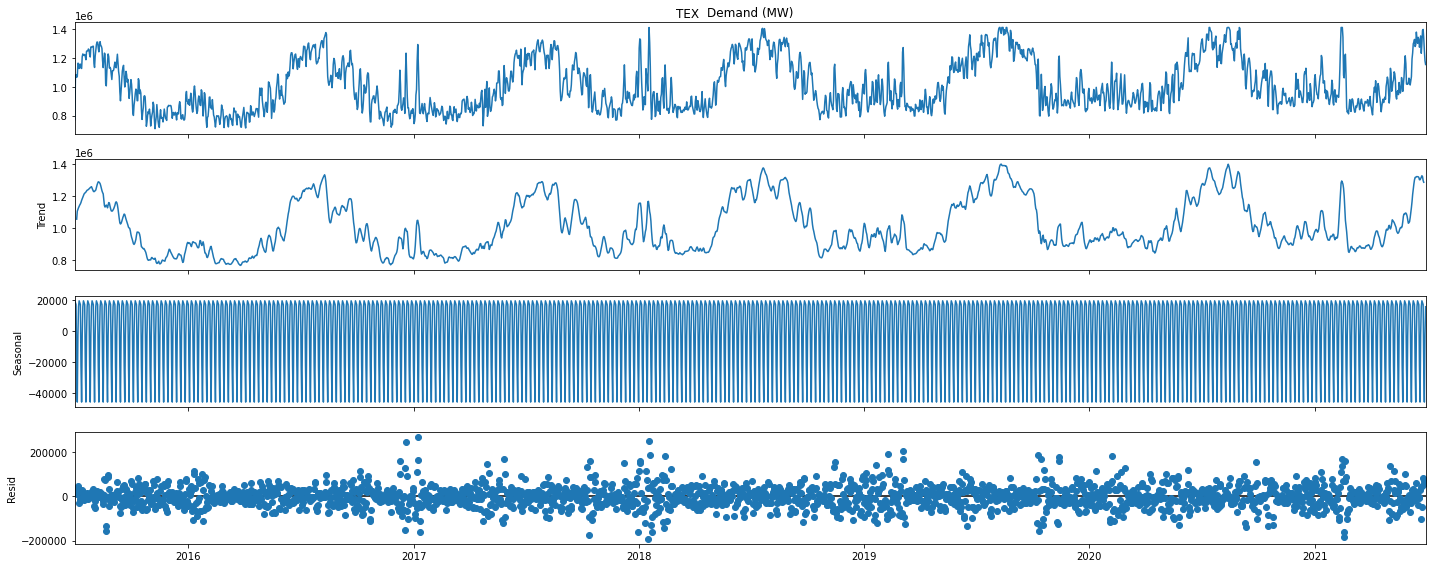

In [51]:
# Seasonal Decomposition Plot for demand in each region
for i in range(len(train_df_lst)):
    plot_seasonal_decompose(train_df_lst[i], 'Demand (MW)' ,file_names[i].split('.')[0], 0.48)

In [26]:
# Adfuller test to check stationarity of timeseries for demands in different regions

def adfuller_stationarity_test(df, col):
    result = adfuller(df[col])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
for i in range(len(train_df_lst)):
    adfuller_stationarity_test(train_df_lst[i], 'Demand (MW)')
    print("----------------------------------------------------------")

ADF Statistic: -3.229006
p-value: 0.018366
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -4.650848
p-value: 0.000104
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -4.657266
p-value: 0.000101
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -3.220824
p-value: 0.018810
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -4.971383
p-value: 0.000025
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -4.270355
p-value: 0.000500
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -4.979406
p-value: 0.000024
Critical Values:
	1%:

* The p-value for these sereis is less than 0.05.

* The results of the adfuller test suggest that time series is trend stationary

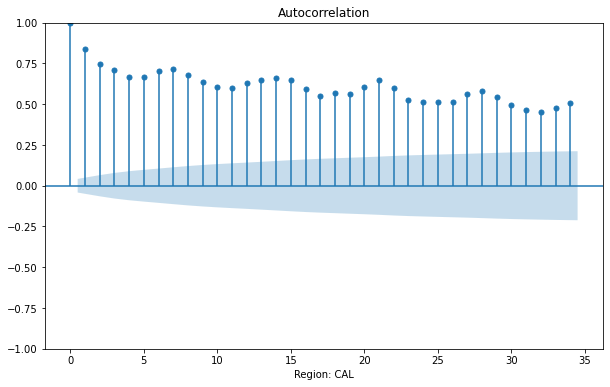

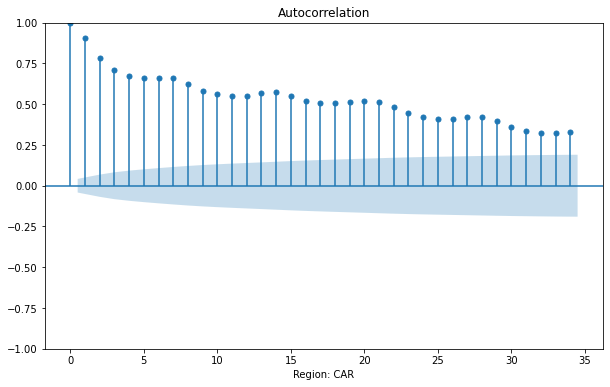

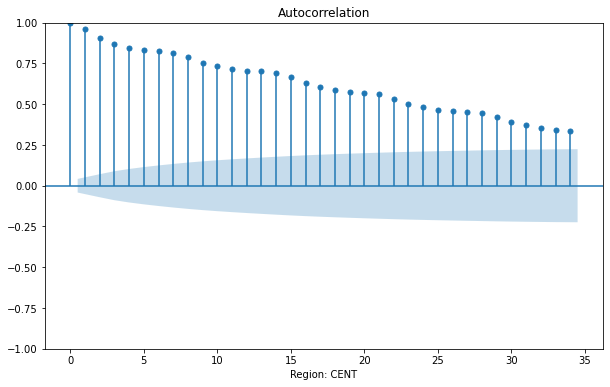

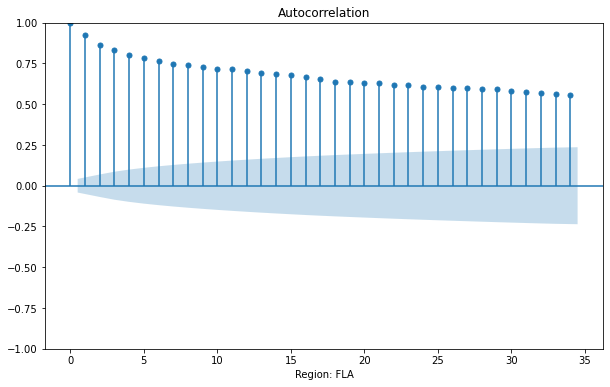

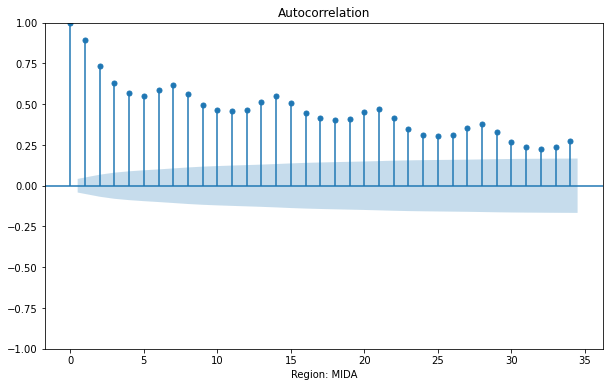

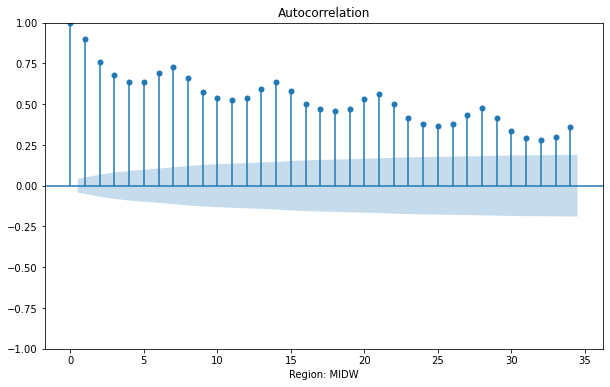

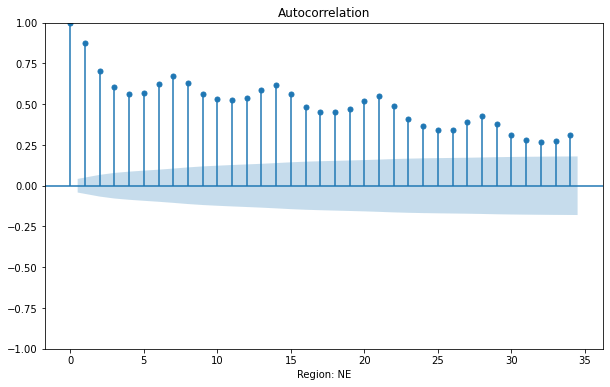

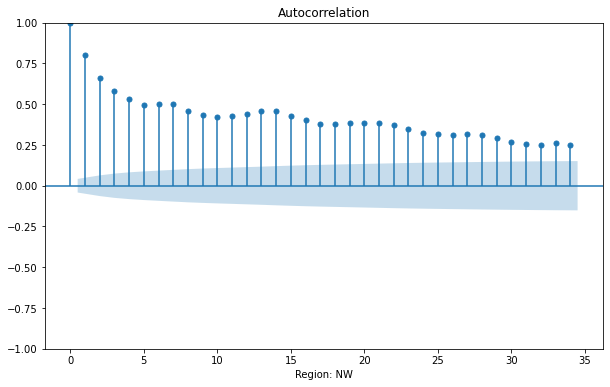

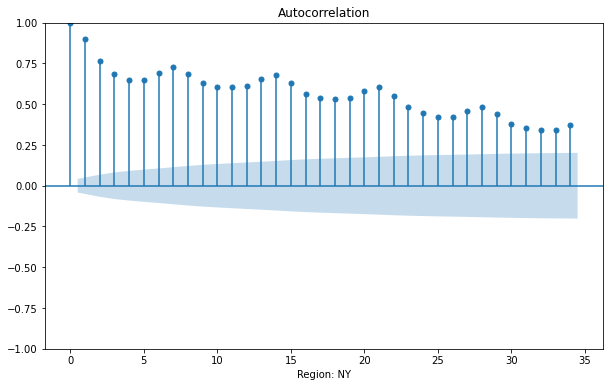

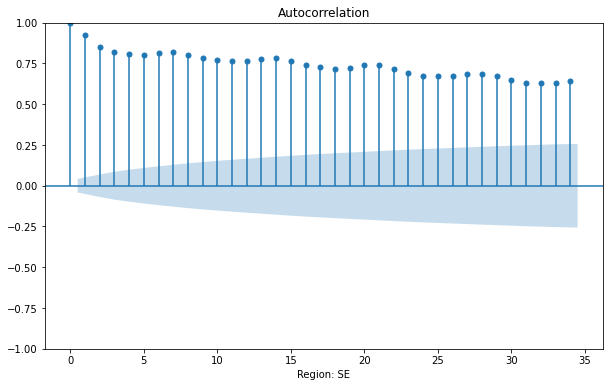

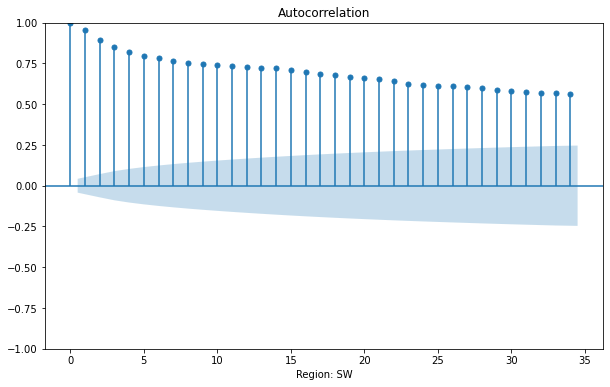

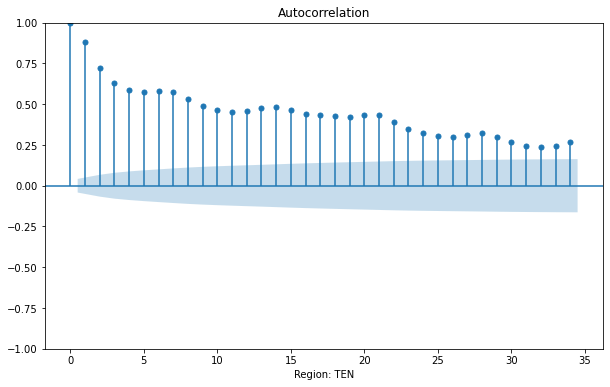

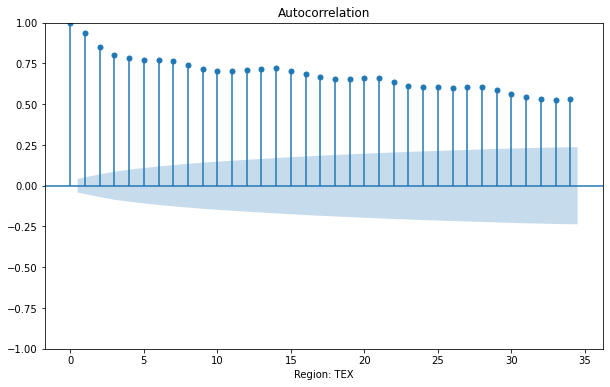

In [28]:
# ACF plots

def acf_plot(df, col, xlabel):
    plt.rcParams["figure.figsize"] = (10, 6)
    plot_acf(df[col])
    plt.xlabel("Region: {}".format(xlabel))
    plt.show()

for i in range(len(train_df_lst)):
    acf_plot(train_df_lst[i], 'Demand (MW)', file_names[i].split('.')[0])

The correlograms show that the time series for all of the regions has a seasonality of 7 days

# Modeling

In [41]:
# Auto Arima for detecting parameters for the SARIMA model
order_list = []
seasonal_order_list = []
for i in range(len(train_df_lst)):
    train_df = train_df_lst[i]['Demand (MW)']
    results_train_df = pm.auto_arima(train_df, seasonal = True, m = 7)
    order_list.append(results_train_df.order)
    seasonal_order_list.append(results_train_df.seasonal_order)

### Walk Forward Cross Validation
In time series modelling, the predictions over time become less and less accurate and hence it is a more realistic approach to re-train the model with actual data as it gets available for further predictions.

In [42]:
def evaluate_arima_model(train, test, order, seasonal_order):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history, order=order, seasonal_order = seasonal_order, initialization='approximate_diffuse')
        model_fit = model.fit(disp = 0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse, predictions

In [44]:
pred_list = []
rmse_list = []
for i in range(len(train_df_lst)):
    print("Calculating: {}".format(file_names[i].split('.')[0]))
    train_df = train_df_lst[i]['Demand (MW)']
    test_df = test_df_lst[i]['Demand (MW)']
    rmse, pred = evaluate_arima_model(train_df, test_df, order_list[i], seasonal_order_list[i])
    rmse_list.append(rmse)
    pred_list.append(pred)

Calculating: CAL
Calculating: CAR
Calculating: CENT
Calculating: FLA
Calculating: MIDA
Calculating: MIDW
Calculating: NE
Calculating: NW
Calculating: NY
Calculating: SE
Calculating: SW
Calculating: TEN
Calculating: TEX


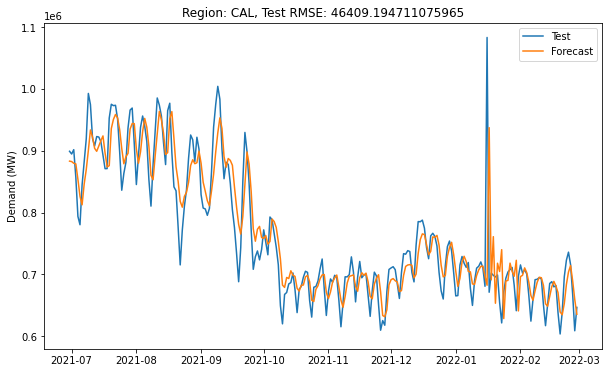

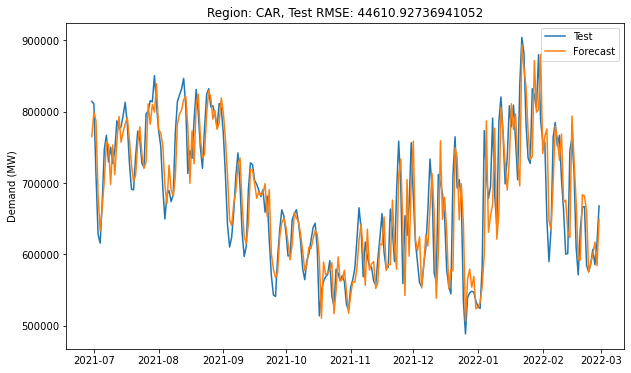

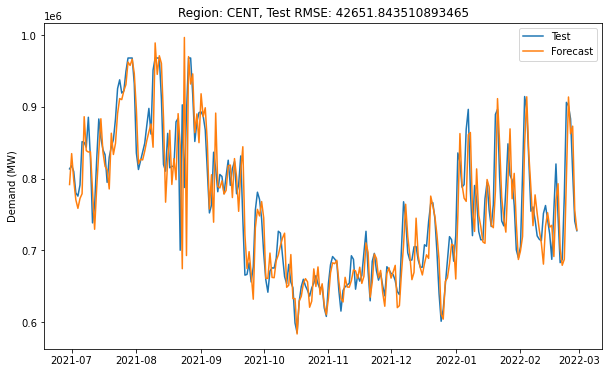

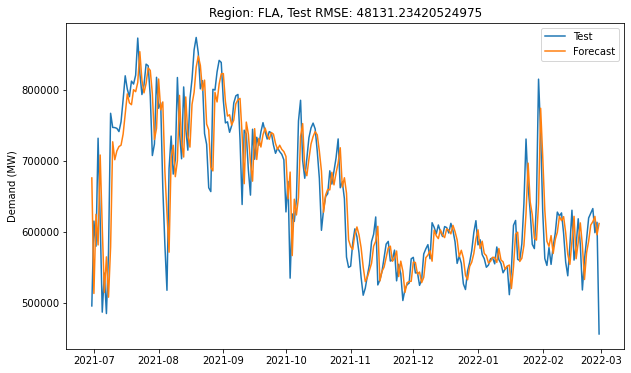

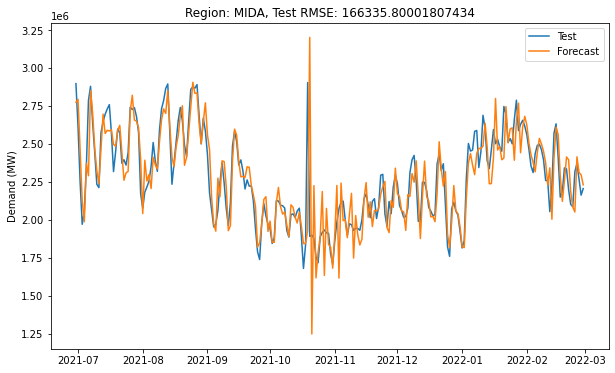

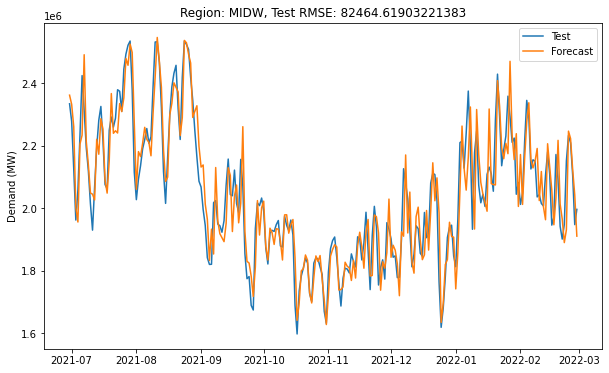

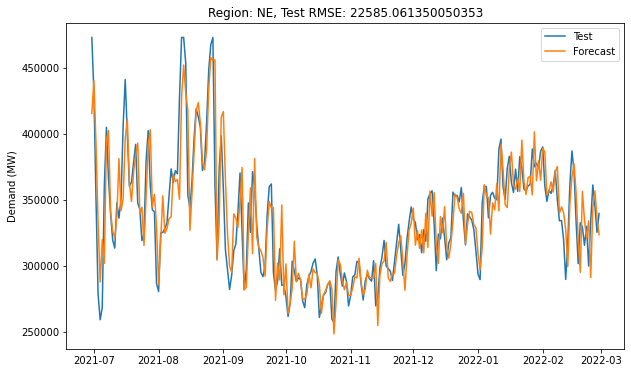

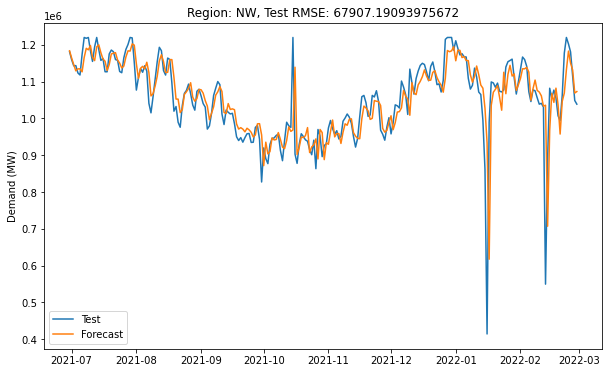

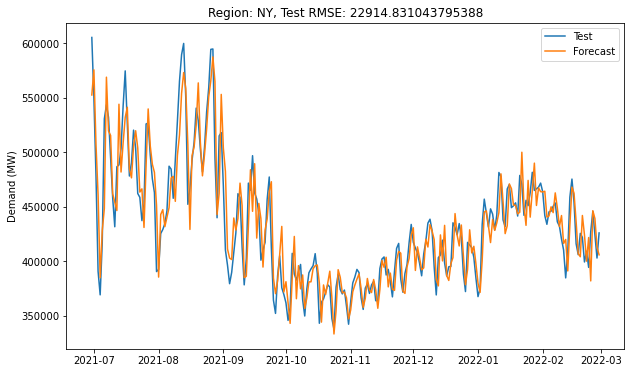

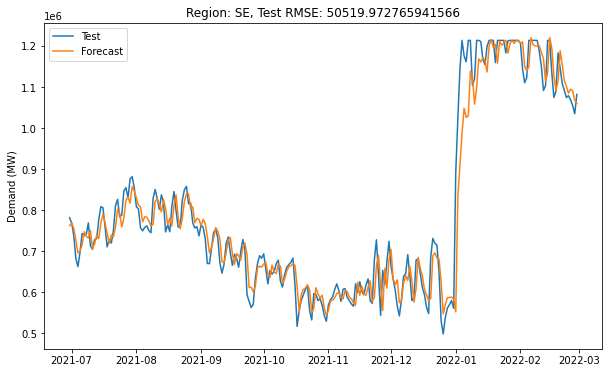

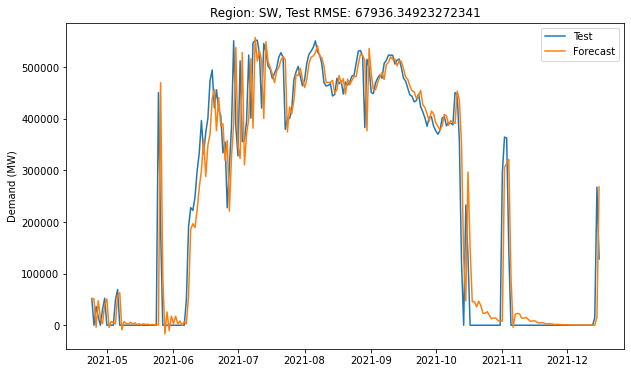

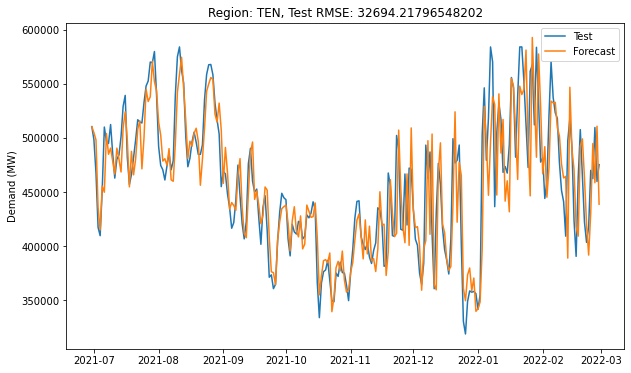

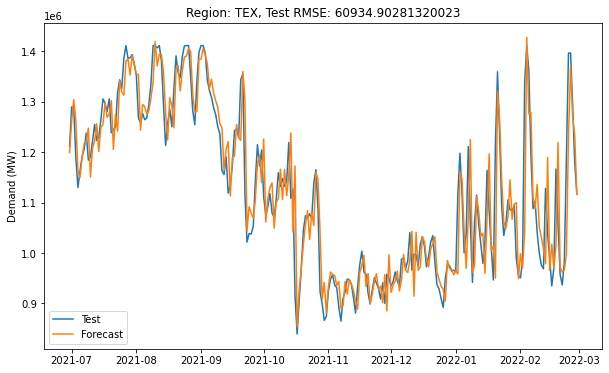

In [45]:
plt.rcParams["figure.figsize"] = (10, 6)
for i in range(len(test_df_lst)):
    plt.plot(test_df_lst[i]['Demand (MW)'], label = 'Test')
    plt.plot(test_df_lst[i].index, pred_list[i], label = 'Forecast')
    plt.ylabel("Demand (MW)")
    plt.legend()
    plt.title('Region: {}, Test RMSE: {}'.format(file_names[i].split('.')[0], rmse_list[i]))
    plt.show()

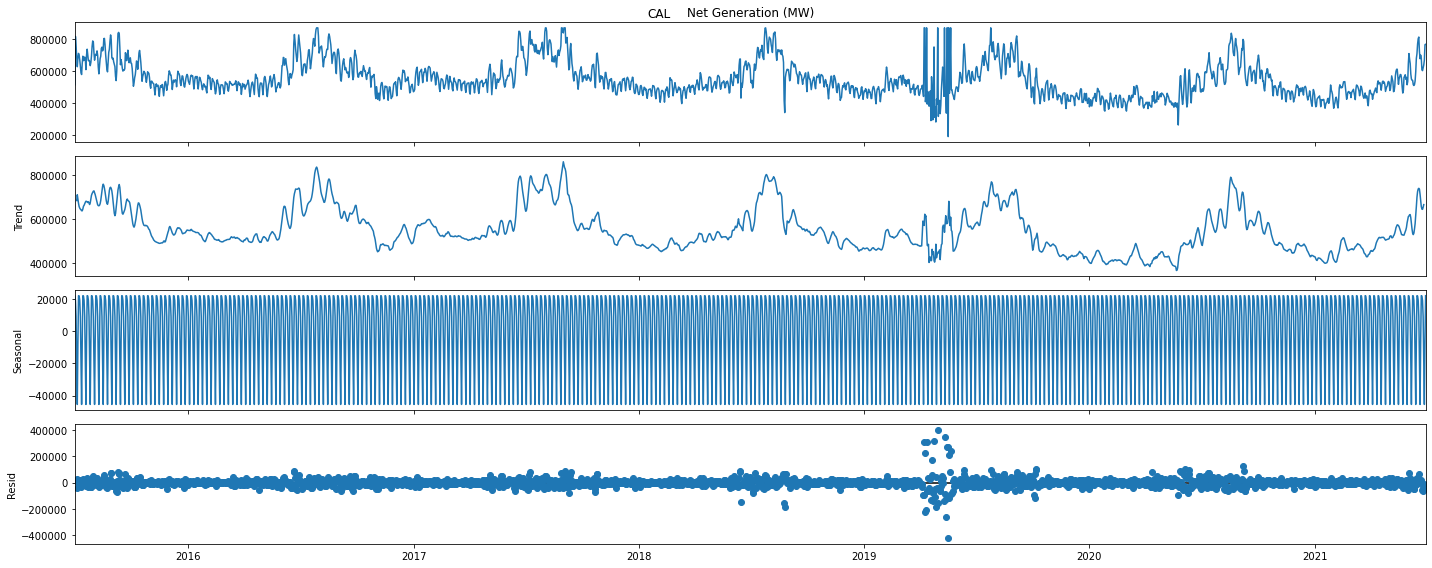

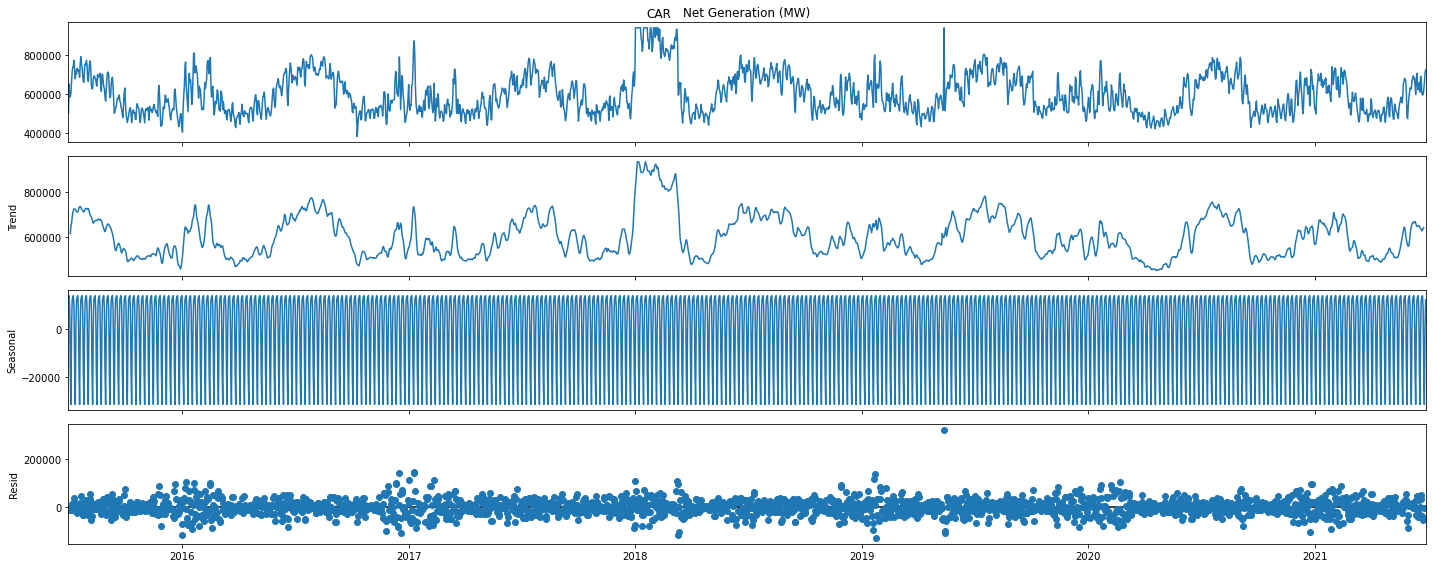

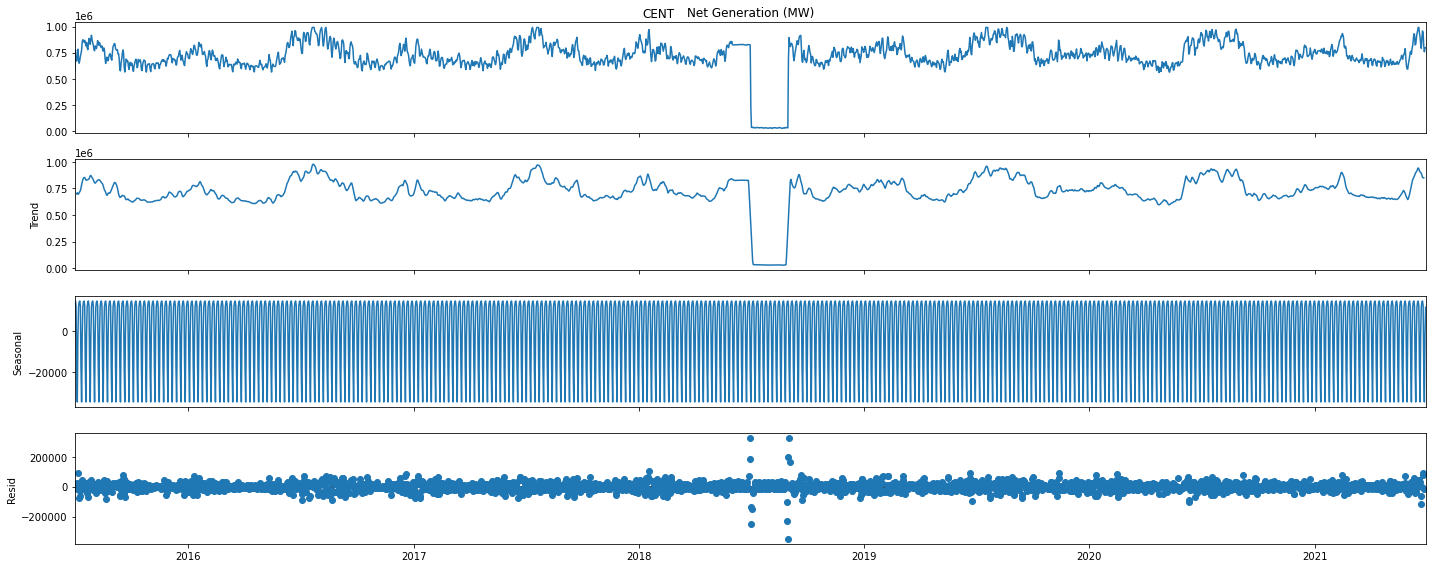

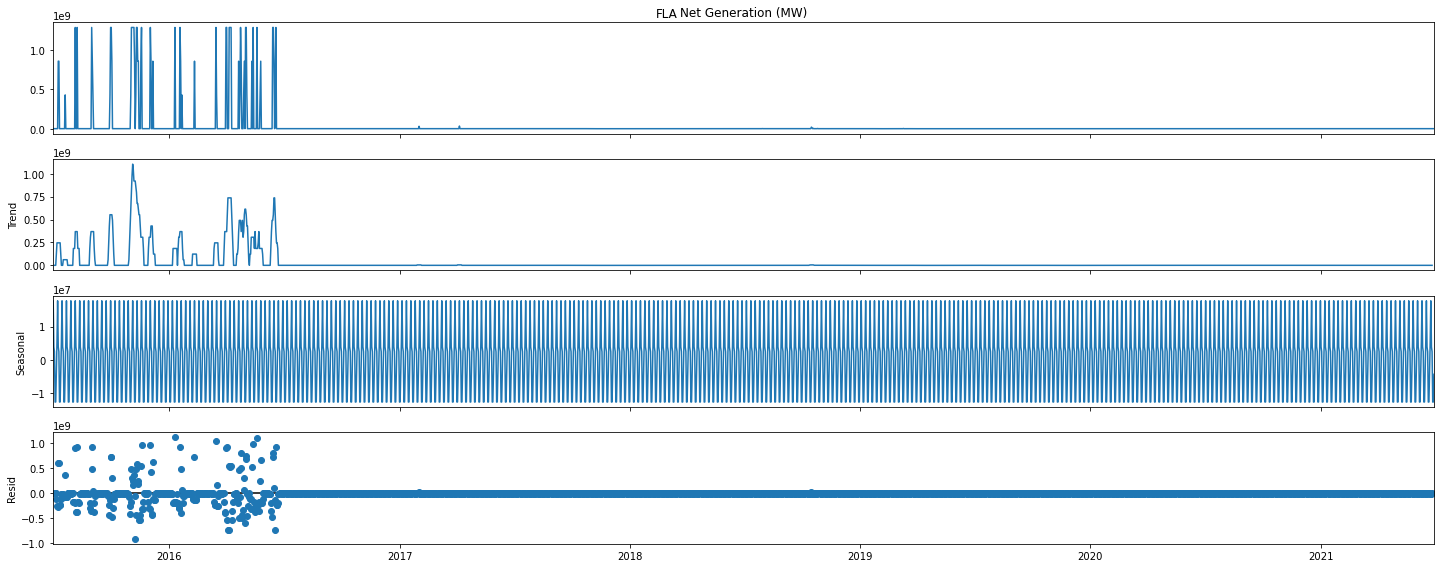

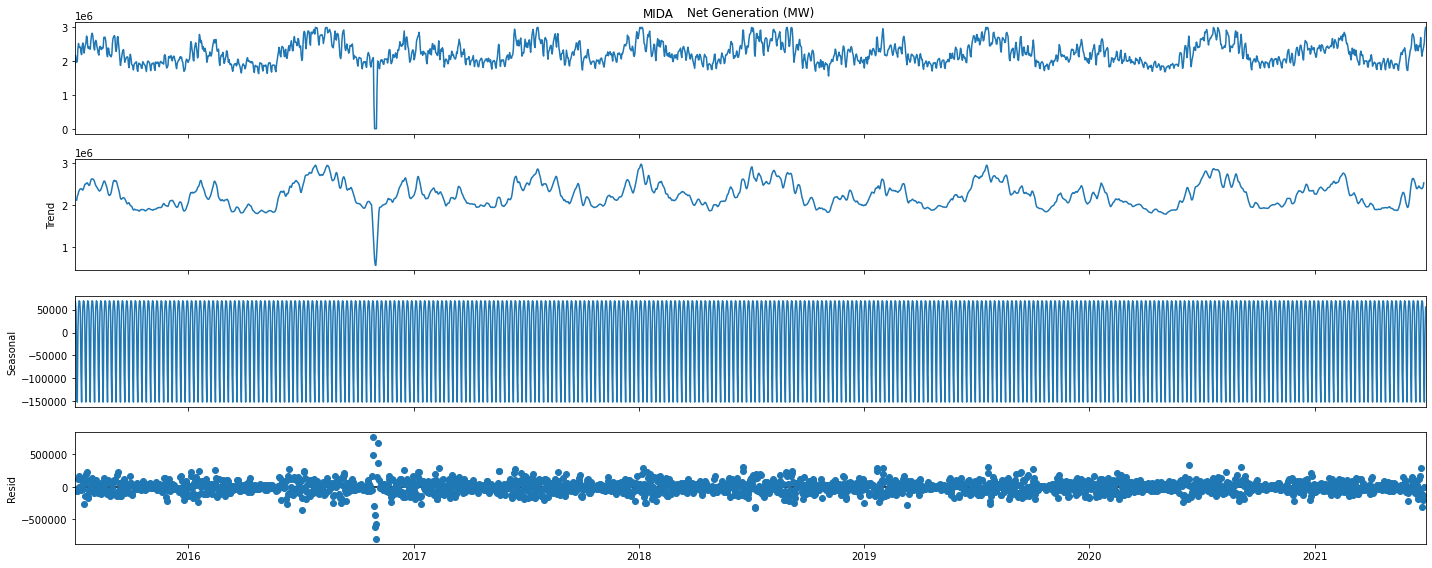

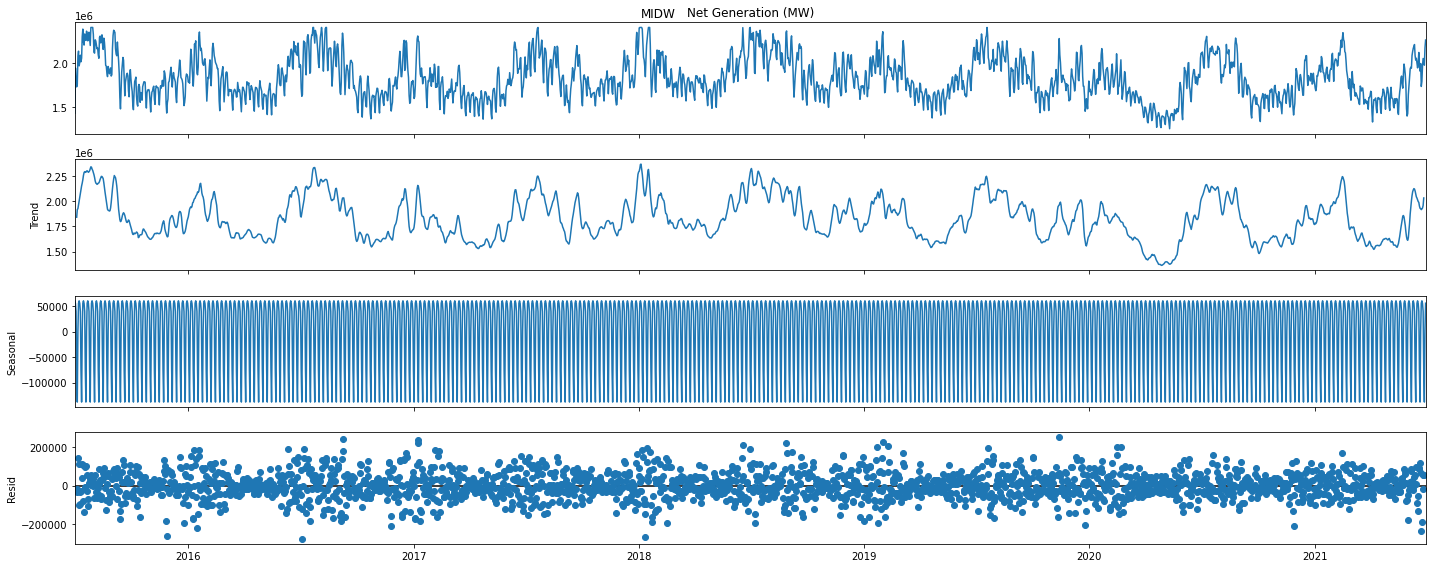

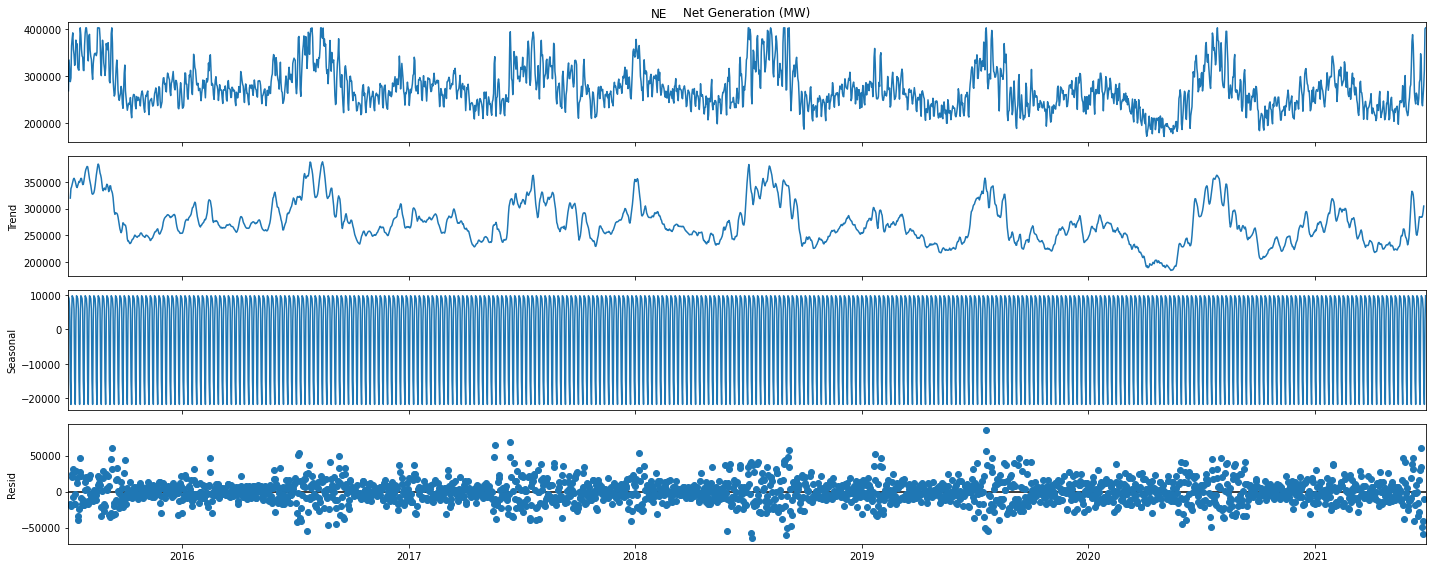

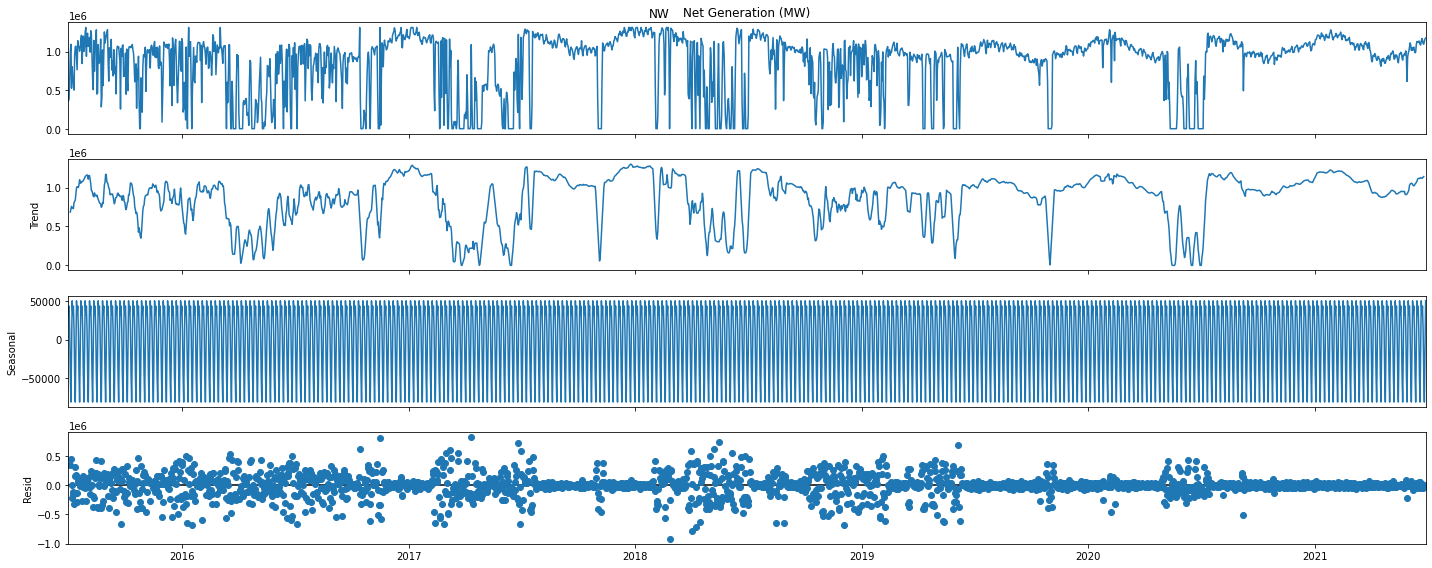

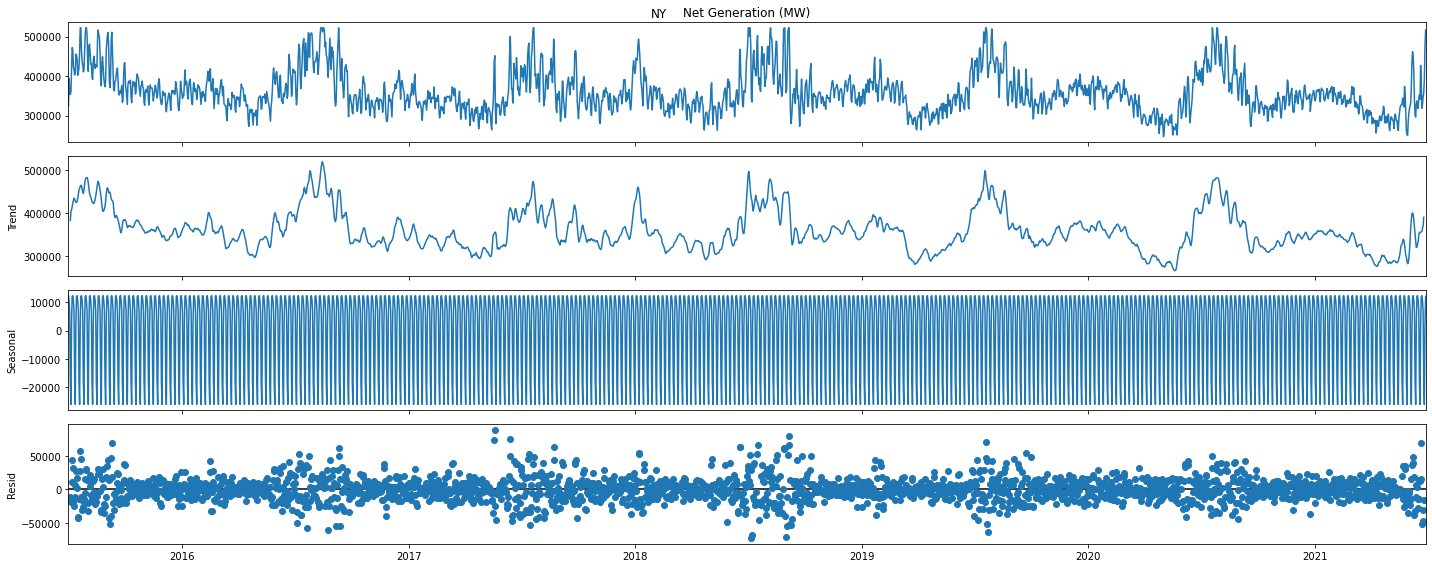

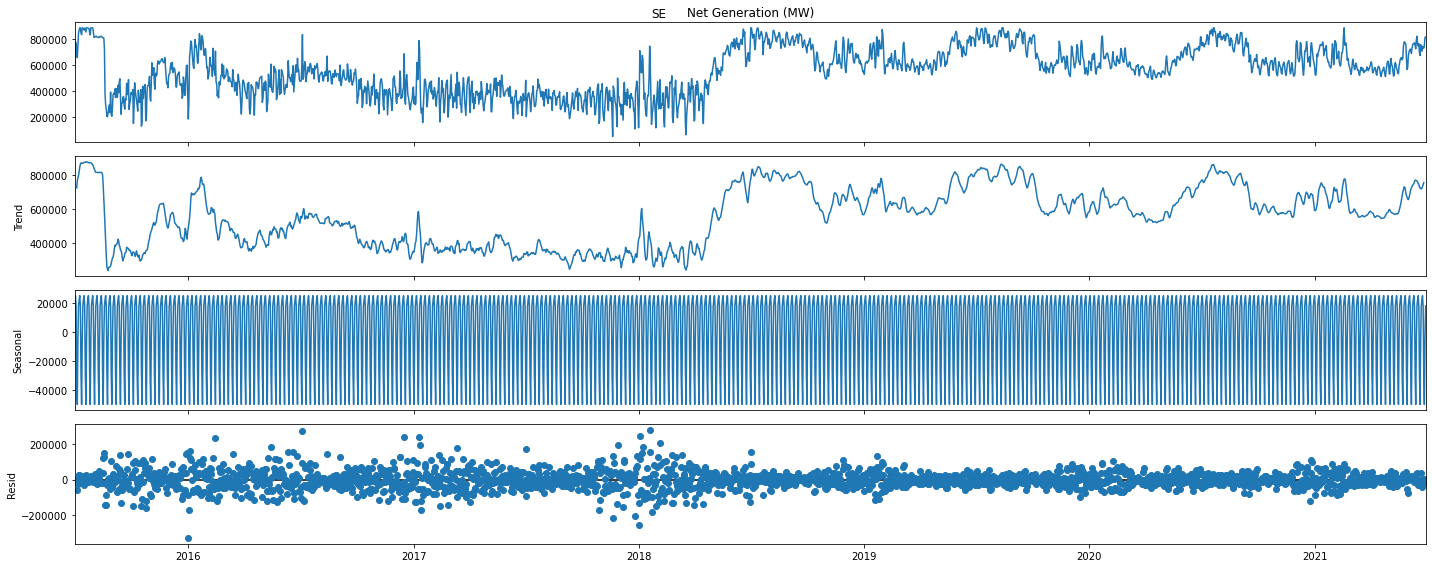

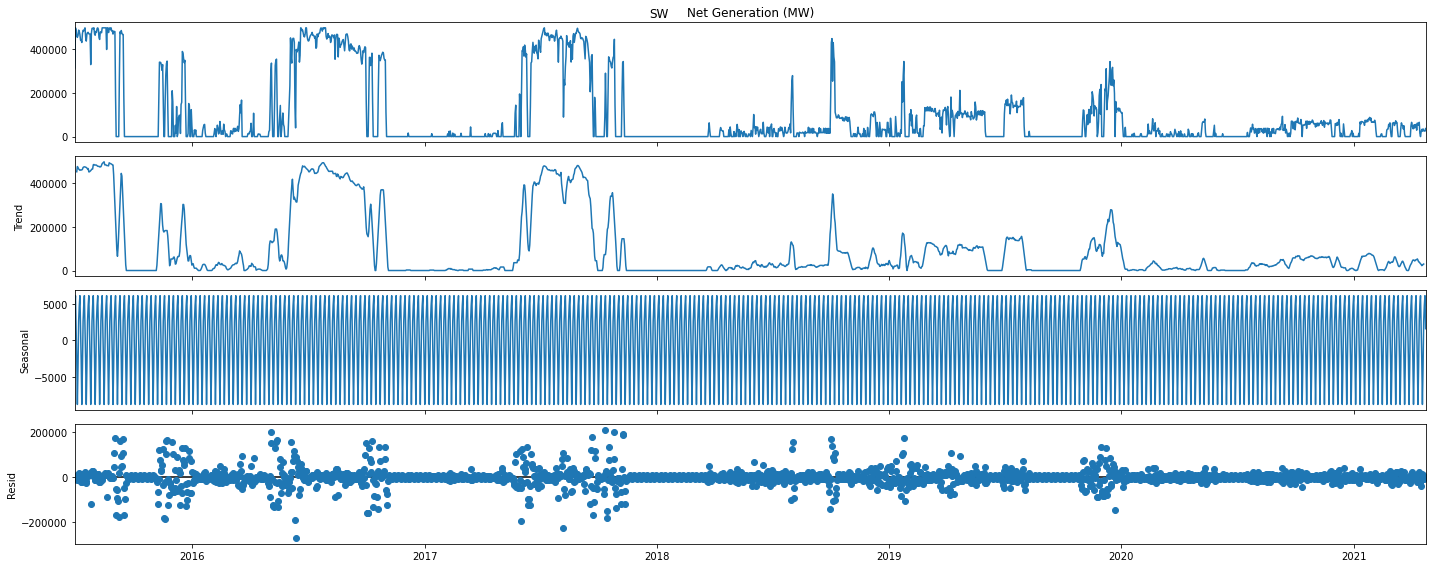

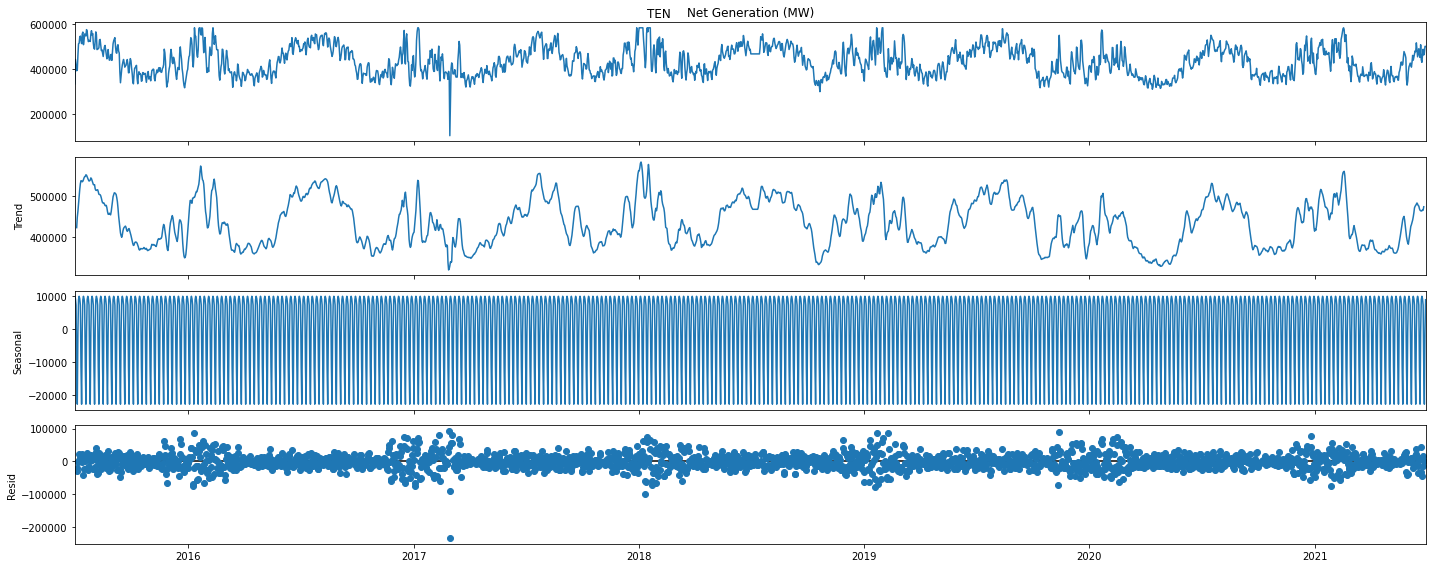

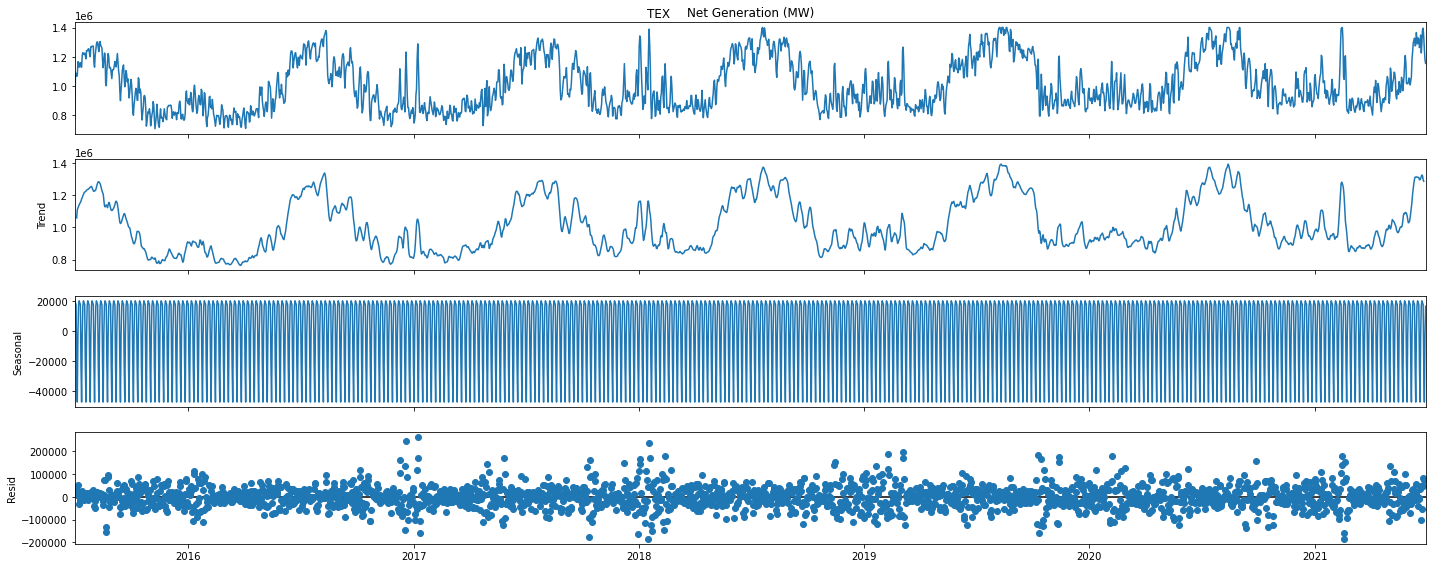

In [53]:
for i in range(len(train_df_lst)):
    plot_seasonal_decompose(train_df_lst[i], 'Net Generation (MW)' ,file_names[i].split('.')[0], 0.46)

In [55]:
for i in range(len(train_df_lst)):
    adfuller_stationarity_test(train_df_lst[i], 'Net Generation (MW)')
    print("----------------------------------------------------------")

ADF Statistic: -3.067909
p-value: 0.029021
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -4.612345
p-value: 0.000123
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -4.787843
p-value: 0.000057
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -5.334112
p-value: 0.000005
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -4.679546
p-value: 0.000092
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -4.320784
p-value: 0.000409
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
----------------------------------------------------------
ADF Statistic: -4.741867
p-value: 0.000070
Critical Values:
	1%:

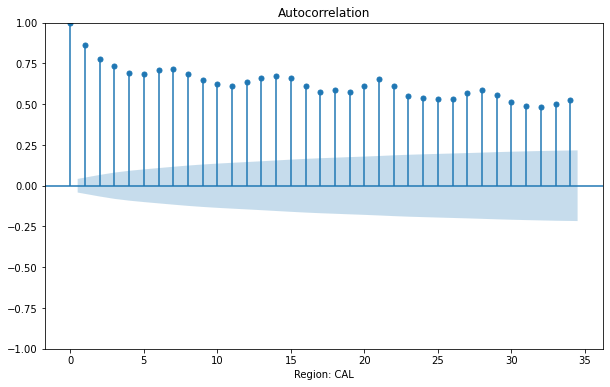

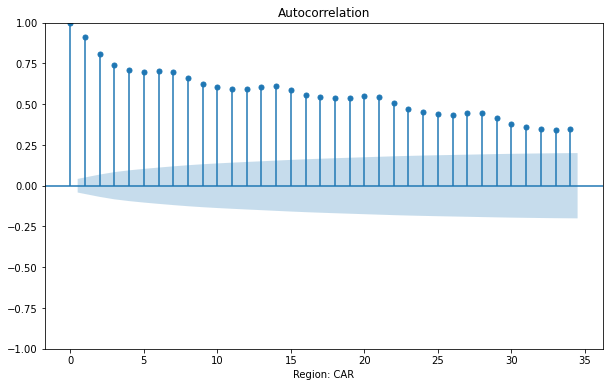

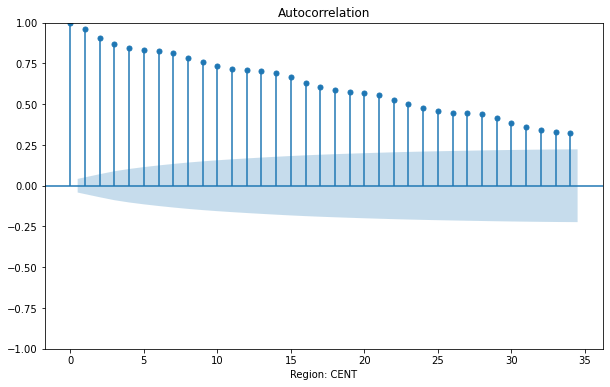

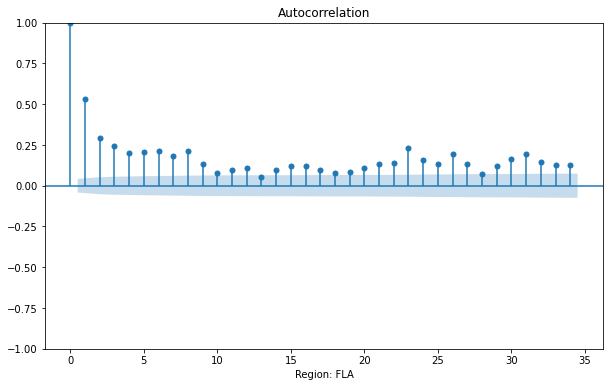

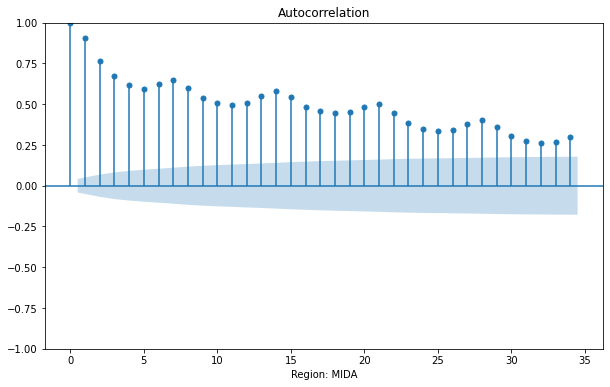

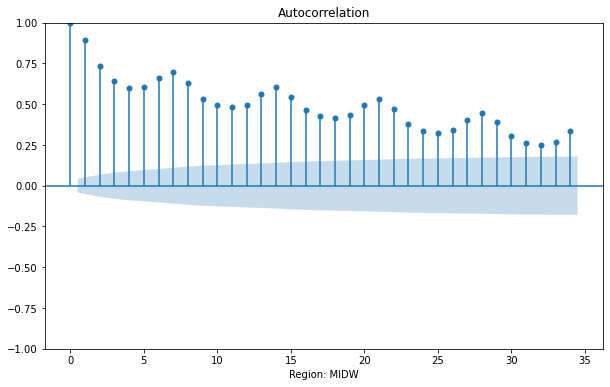

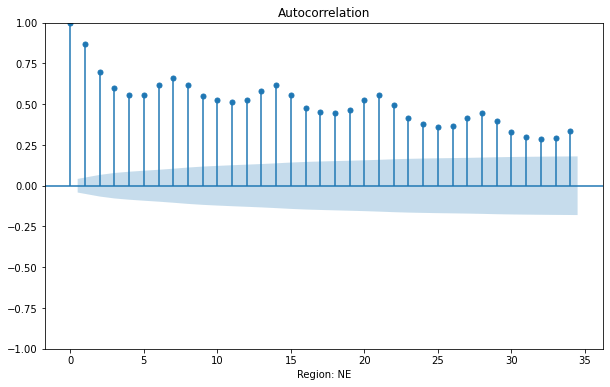

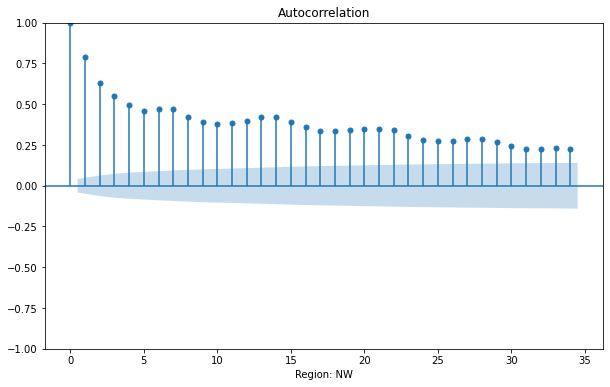

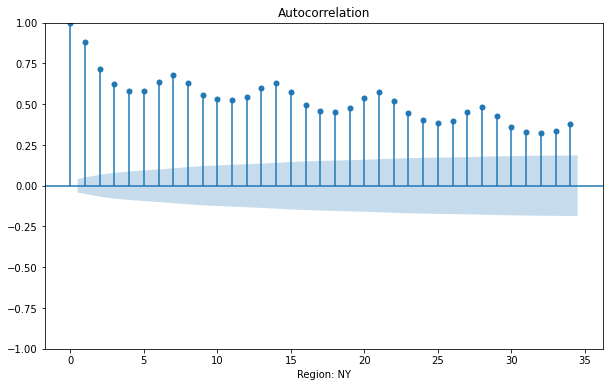

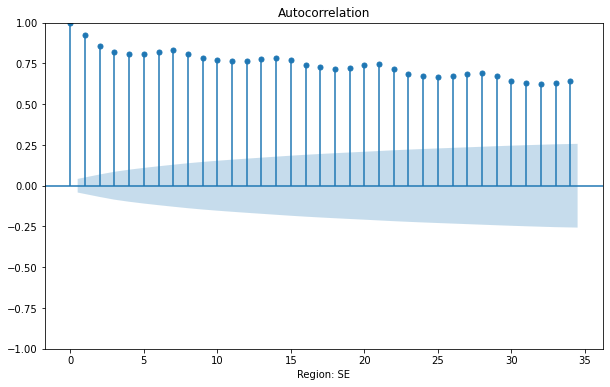

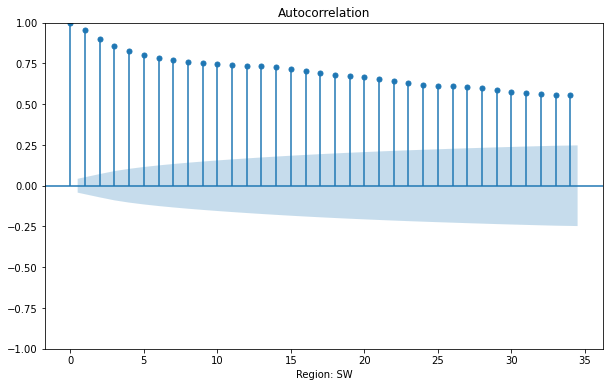

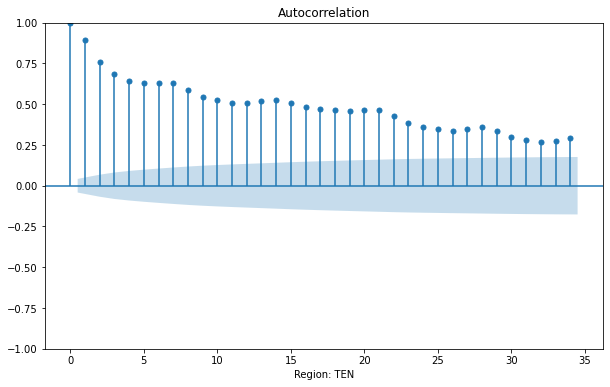

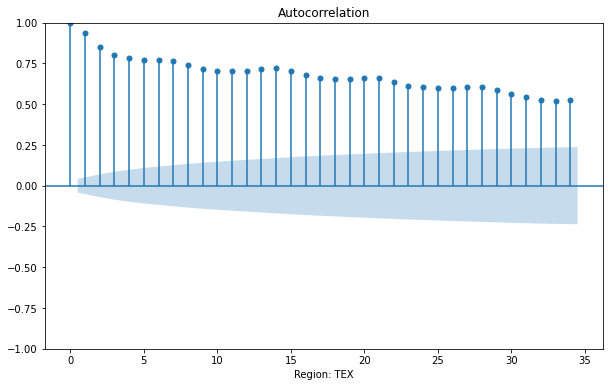

In [54]:
for i in range(len(train_df_lst)):
    acf_plot(train_df_lst[i], 'Net Generation (MW)', file_names[i].split('.')[0])

In [56]:
# Auto Arima for detecting parameters for the SARIMA model
order_list = []
seasonal_order_list = []
for i in range(len(train_df_lst)):
    train_df = train_df_lst[i]['Net Generation (MW)']
    results_train_df = pm.auto_arima(train_df, seasonal = True, m = 7)
    order_list.append(results_train_df.order)
    seasonal_order_list.append(results_train_df.seasonal_order)

In [57]:
pred_list = []
rmse_list = []
for i in range(len(train_df_lst)):
    print("Calculating: {}".format(file_names[i].split('.')[0]))
    train_df = train_df_lst[i]['Net Generation (MW)']
    test_df = test_df_lst[i]['Net Generation (MW)']
    rmse, pred = evaluate_arima_model(train_df, test_df, order_list[i], seasonal_order_list[i])
    rmse_list.append(rmse)
    pred_list.append(pred)

Calculating: CAL
Calculating: CAR
Calculating: CENT
Calculating: FLA
Calculating: MIDA
Calculating: MIDW
Calculating: NE
Calculating: NW
Calculating: NY
Calculating: SE
Calculating: SW
Calculating: TEN
Calculating: TEX


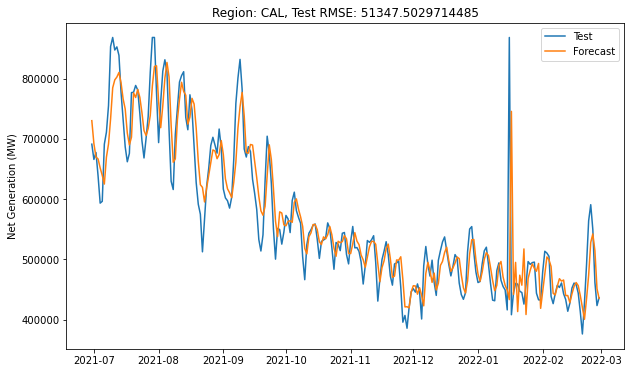

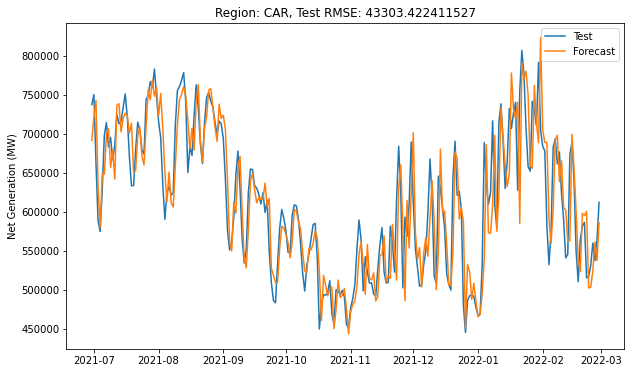

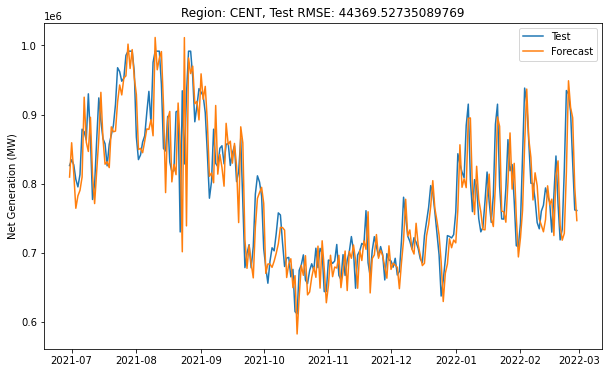

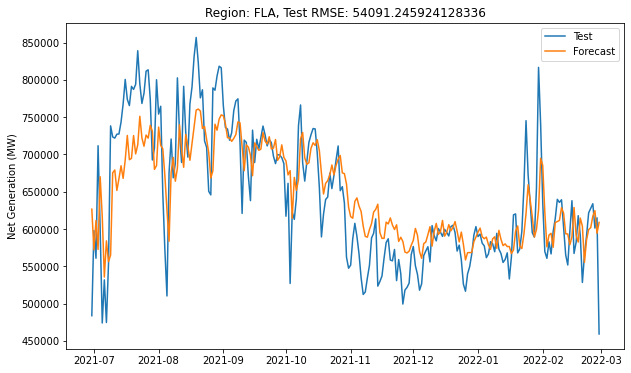

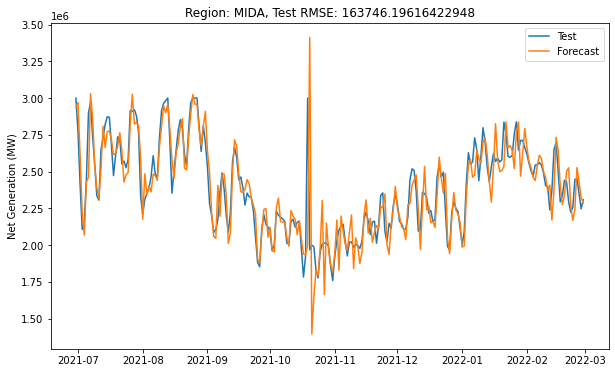

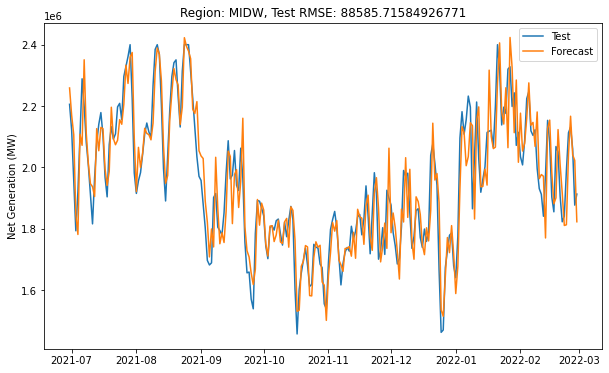

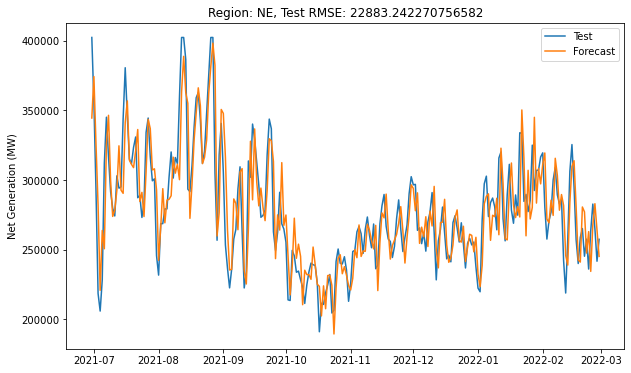

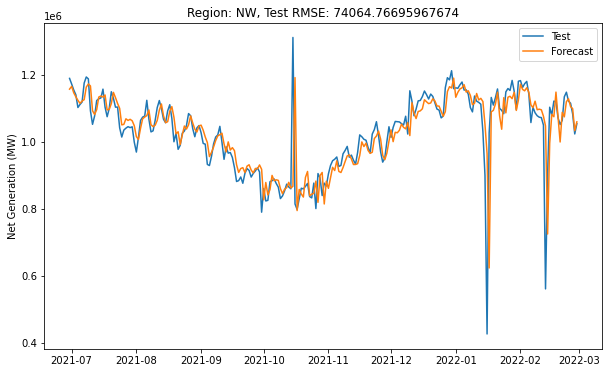

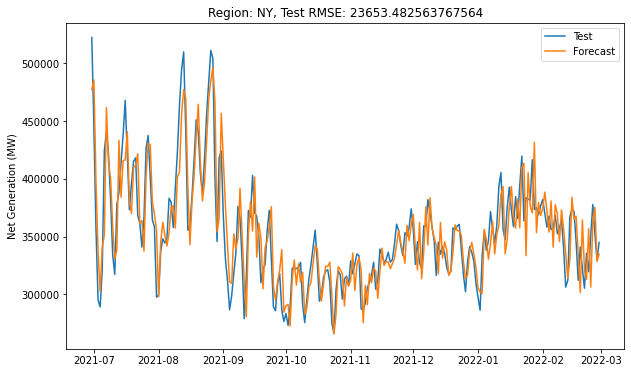

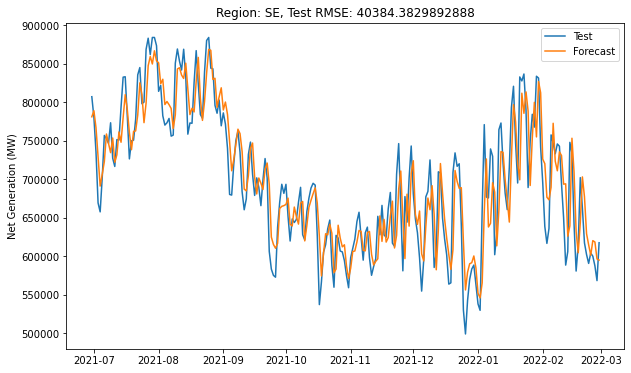

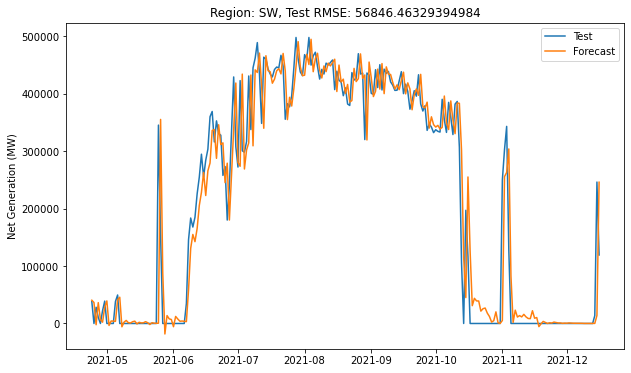

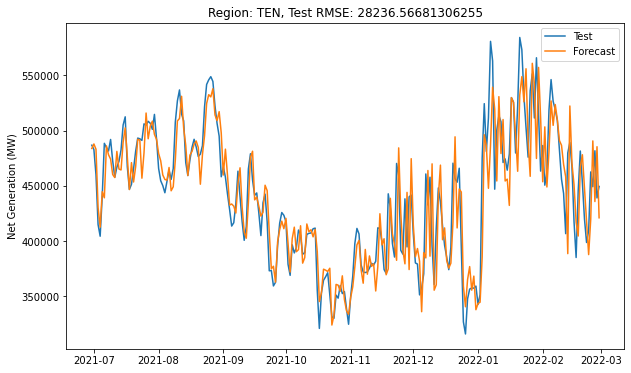

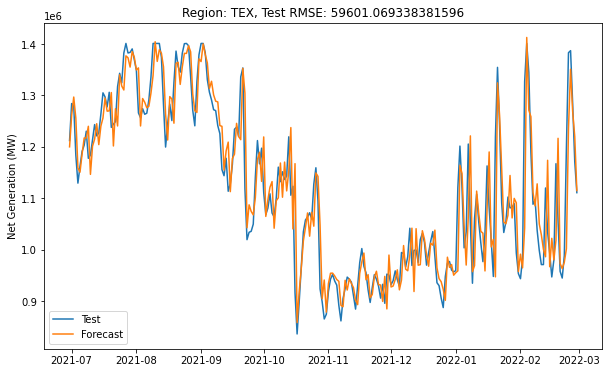

In [58]:
plt.rcParams["figure.figsize"] = (10, 6)
for i in range(len(test_df_lst)):
    plt.plot(test_df_lst[i]['Net Generation (MW)'], label = 'Test')
    plt.plot(test_df_lst[i].index, pred_list[i], label = 'Forecast')
    plt.ylabel("Net Generation (MW)")
    plt.legend()
    plt.title('Region: {}, Test RMSE: {}'.format(file_names[i].split('.')[0], rmse_list[i]))
    plt.show()